# Exploration 4

=====================================================================

# 목차

## (1) 프로젝트 : 주식 예측에 도전해보자!
> ## 1. 프로젝트 : 주식 예측에 도전해보자! - 기아차 (000270.KS)
> ## 2. 프로젝트 : 주식 예측에 도전해보자! - 한화솔루션 (009830.KS)
> ## 3. 프로젝트 : 주식 예측에 도전해보자! - 만도 (204320.KS)
## (2) 회고

## (3) Reference

## (4) 자기다짐

---

## 루브릭 평가 기준

1. 시계열의 안정성이 충분히 확인되었는가?
   - 플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
   - p,q를 위한 ACF,PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
   - 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

# (1) 프로젝트 : 주식 예측에 도전해보자!

## __1. 프로젝트 : 주식 예측에 도전해보자! - 기아차 (000270.KS)__

## STEP 1 : 시계열 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import statsmodels

import warnings
warnings.filterwarnings('ignore')

- 필요한 라이브러리들을 import 했습니다.

In [2]:
kia_df = pd.read_csv('./data/kia_01.csv')

In [3]:
kia_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,62400.0,64800.0,61700.0,64000.0,61727.808594,5602314
1,2021-01-05,64100.0,64500.0,62300.0,63700.0,61438.460938,3837356
2,2021-01-06,63700.0,64100.0,62000.0,62200.0,59991.714844,2772352
3,2021-01-07,62400.0,63700.0,62300.0,63000.0,60763.312500,3144465
4,2021-01-08,68000.0,72100.0,64600.0,68300.0,65875.148438,25357804


- 데이터를 불러와 데이터의 정보를 확인해봅니다.

In [4]:
kia_ts = kia_df['Close']

- 저흰 데이터에서 Close 컬럼만 사용하도록 하겠습니다.

In [5]:
kia_ts

0      64000.0
1      63700.0
2      62200.0
3      63000.0
4      68300.0
        ...   
243    85100.0
244    84800.0
245    84500.0
246    83400.0
247    82200.0
Name: Close, Length: 248, dtype: float64

- 제대로 할당이 된것을 확인할 수 있습니다.

## STEP 2 : 각종 전처리 수행

### 결측치 처리

In [6]:
kia_ts.isna().sum()

0

- 결측치가 없는것을 확인할 수 있습니다.

## STEP 3 : 시계열 안정성 분석

### 정성적 그래프 분석

In [7]:
def plot_rolling_statistics(timeseries, window=30):
    rolmean = timeseries.rolling(window=window).mean() # 이동평균
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차
    
    plt.figure(figsize=(12,8))
    origin = plt.plot(timeseries, color='black', label = 'Original')
    mean = plt.plot(rolmean, color='green', label = 'Rolling mean')
    std = plt.plot(rolstd, color = 'blue', label = 'Rolling std')
    plt.legend(loc='best') # loc=best란 좋은 위치에 놓으라는것.
                           # ncol=1, ncol=2 는 columns을 만들라는것
                           # loc = (0.5, 0.5) , loc = 'lower right' 처럼 위치 지정 가능
    plt.title('Rolling mean & std')
    plt.show(block = False)

- plot_rolling_statistics 함수는 구간 통계치를 시각화하는 함수로 이동평균선과 이동표준편차선을 구하여 원본 시계열 그래프와 비교하여 경향성을 확인해보기 위한 함수입니다.

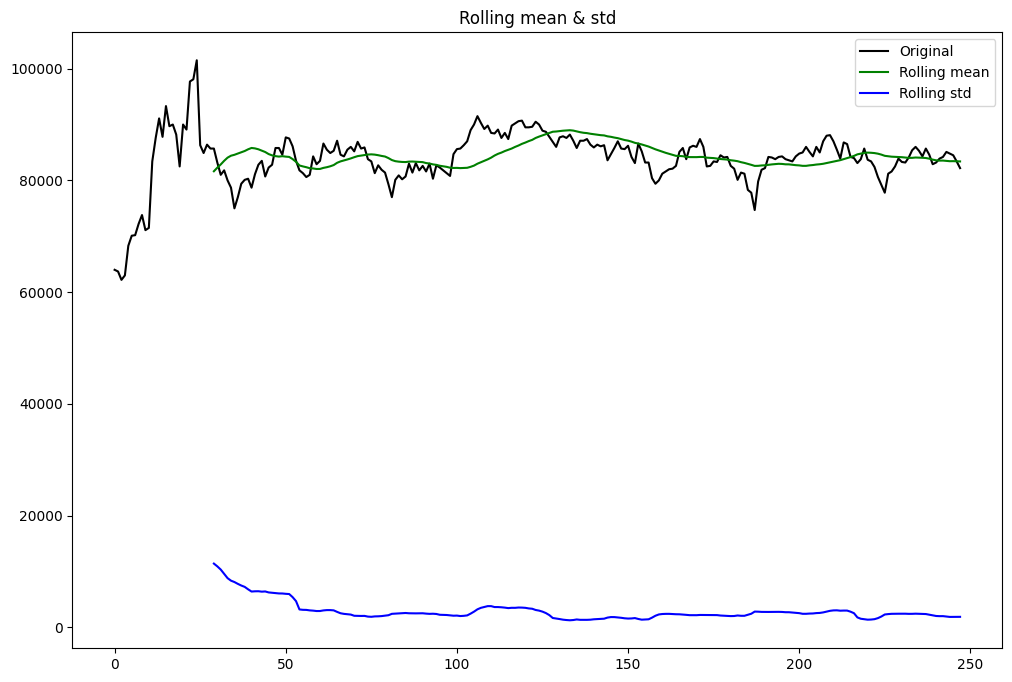

In [8]:
plot_rolling_statistics(kia_ts)

- 그래프가 잘 그려졌군요. 변동폭이 일정하지 않으니 데이터를 log화 시켜주도록 하겠습니다.

In [9]:
kia_log = np.log1p(kia_ts)

- log화를 시켜주는 이유는 데이터의 변동폭이 일정하지 않아 정상성을 띄지 않기 때문이다.

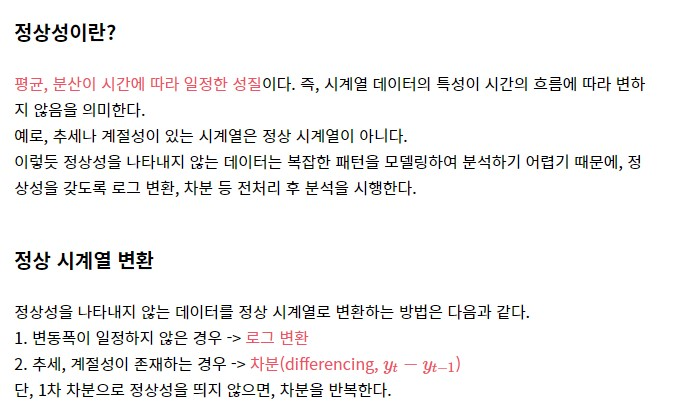

---
- Exploration LMS 에서는 데이터를 log화 하여 그래프를 그렸으나 여러번 시도하던 중 왠지 오류인거같아 log화 하지 않은 데이터로 그렸습니다.
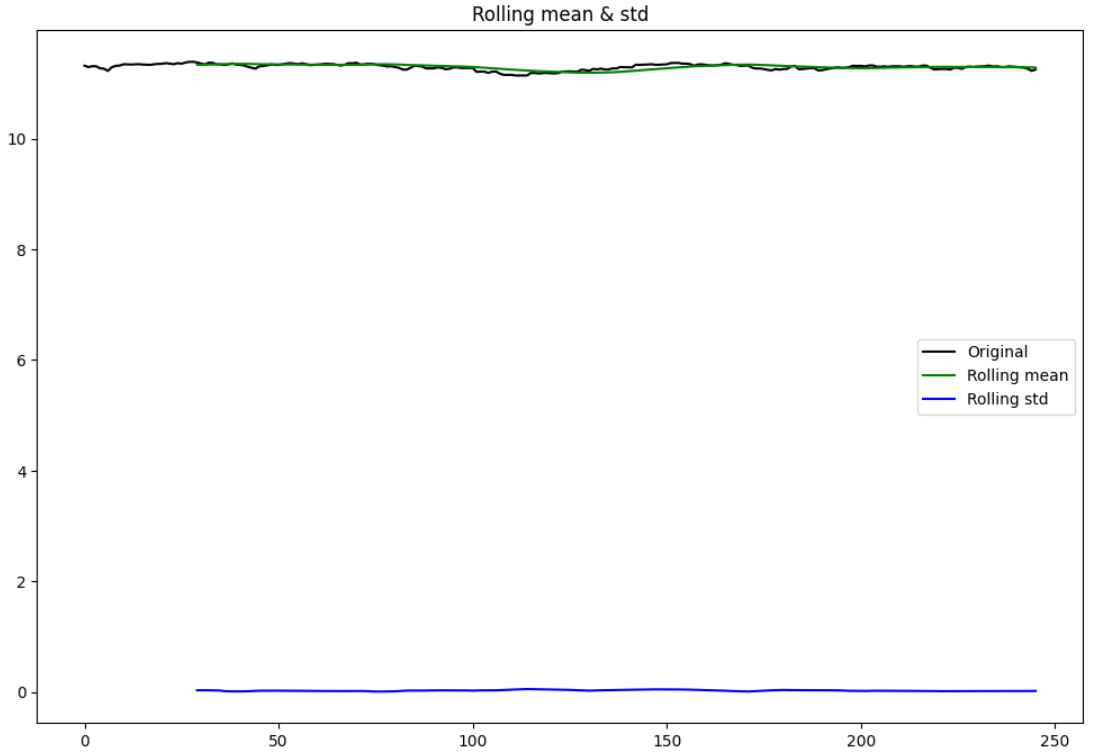

### 정량적 ADF test

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of ADF test')
    dfoutput = pd.Series(dftest[:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in dftest[4].items():
        dfoutput['Critical Value (%s)' %k] = v
        
    print(dfoutput)

- statsmodels 라이브러리는 다양한 통계 모델의 추정 및 통계 테스트, 통계 데이터 탐색을 수행하기 위한 클래스와 함수를 제공하는 모듈입니다.
  
  
- 그 중 adfuller 함수를 불러와 사용하겠습니다.
- adfuller 함수란 ADF Test 라고 불리며 시계열의 안정성을 확인하는 test 입니다.

In [11]:
augmented_dickey_fuller_test(kia_log)

Results of ADF test
Test Statistic                  -4.939711
p-value                          0.000029
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- p-value 값을 보니 현재 데이터셋은 통계적으로 유의미한 값을 가진다고 볼 수 있습니다.
- p-value 값을 보는 이유는 대립가설을 채택하기 위함입니다.
- 일반적으로 95% 신뢰기준 == (alpha = 0.05)를 사용하기에 p-value값이 0.05 이하인 경우 stable한 데이터라고 판단할 수 있습니다.
  
  
  
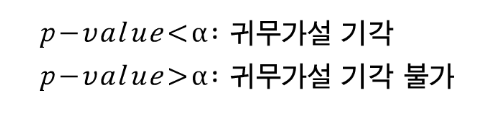

### 시계열 분해

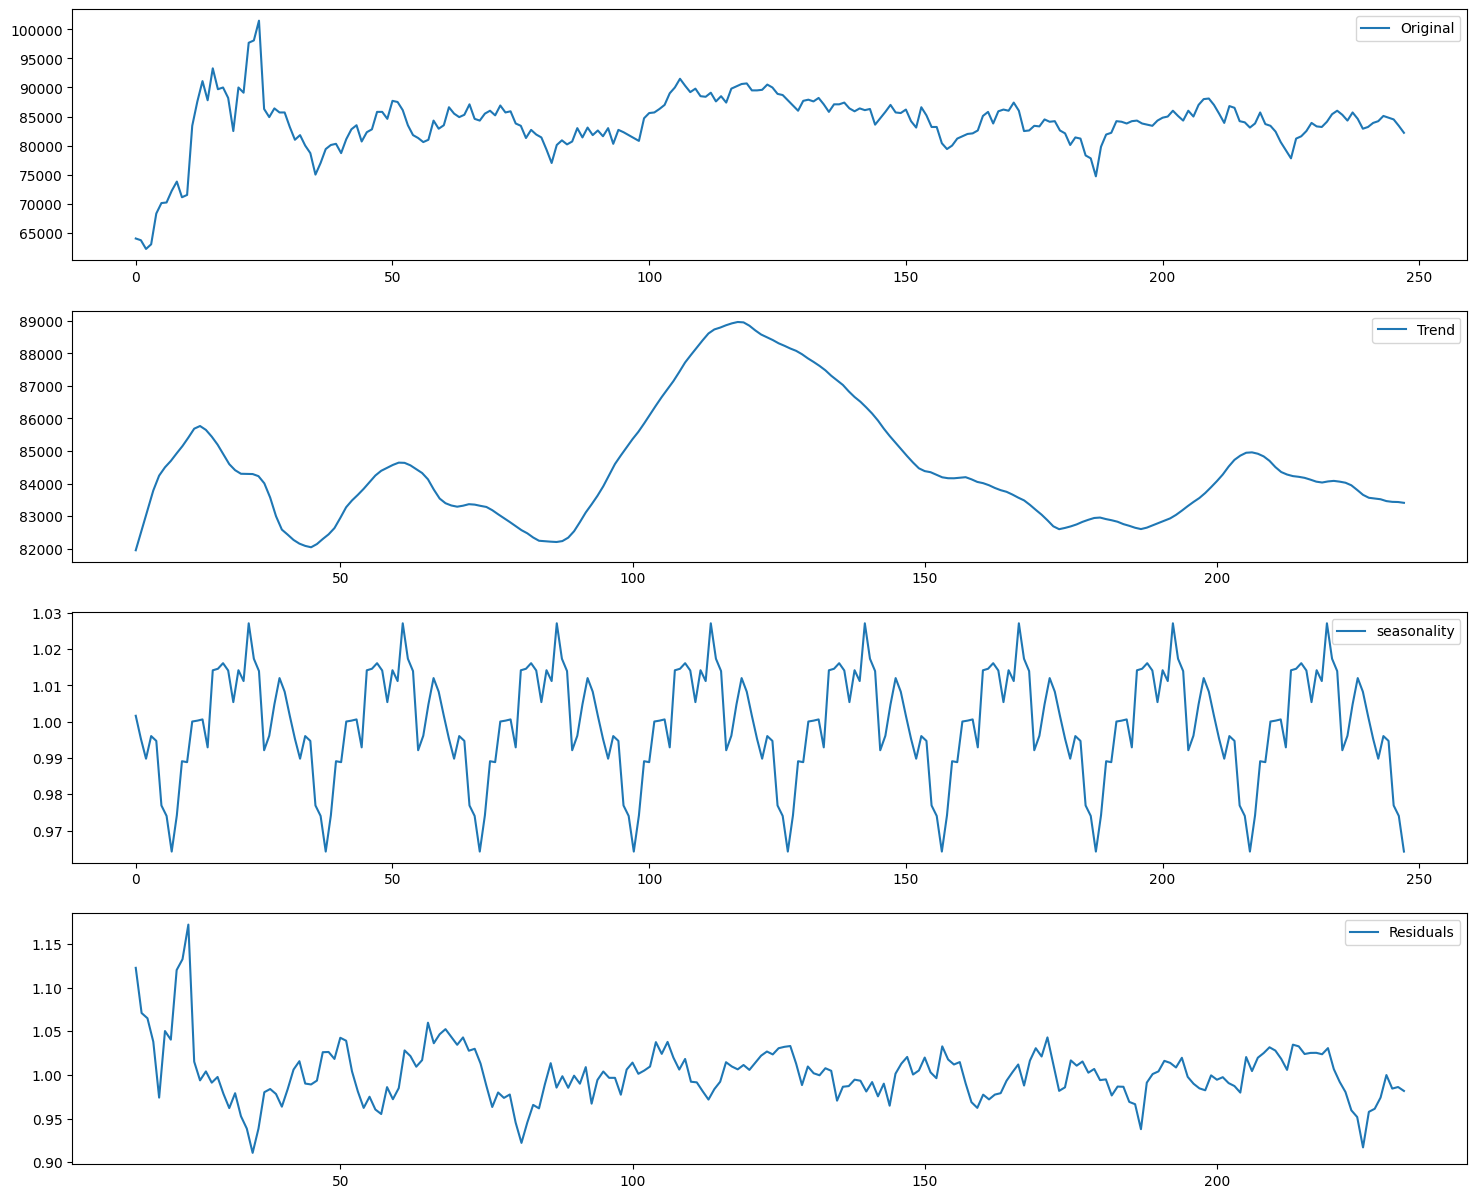

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams

decomposition = seasonal_decompose(kia_ts, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams['figure.figsize'] = (18, 15)
plt.subplot(411)
# plt.plot(kia_log, label='Original')
plt.plot(kia_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

### 계절성이란?
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 __패턴이 파악되지 않은 주기적 변화__ 는 예측에 방해가 되는 불안정한 요소이며 이런 계절적, 주기적 패턴을 계절성(Seasonality) 라고 합니다.
  
  
- 이를 제거하기 위한 방법으로는 차분(Differencing)이 있습니다.
  
  
  
- 분해를 해보았더니 추세와 계절성을 띄고있는 것을 확인할 수 있습니다.
- 차분을 해서 stable하게 만들어줘야겠습니다.

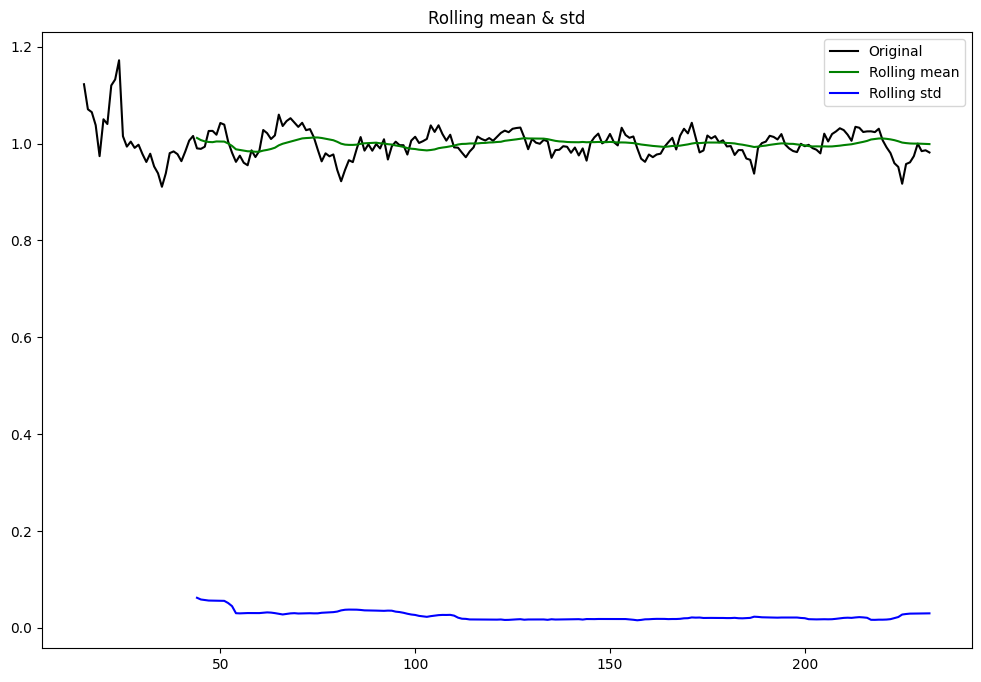

In [13]:
plt.rcParams["figure.figsize"] = (18,12)
plot_rolling_statistics(residual)

> __rcParams란?__
> - Runtime Configuration Parameters 라고 하며
> - rcParams는 딕셔너리의 값을 이용하여 그래프를 그리는 함수입니다.
> - rcParams의 딕셔너리 값을 바꿔주면 backend에서 그릴 때 폰트 사이즈, 바탕색 등 여러 성질을 바꾸어 그리게 됩니다.
  
  
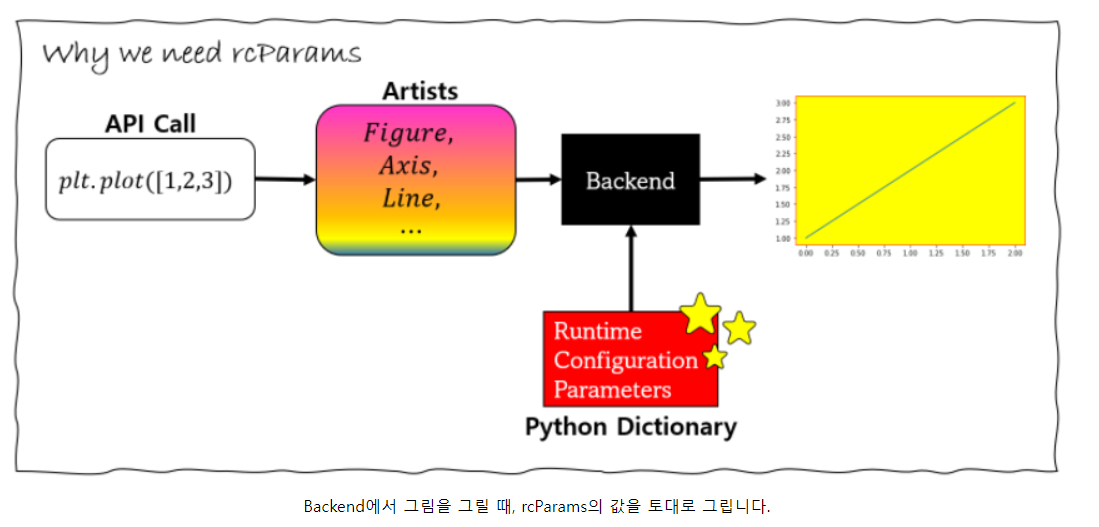

In [14]:
residual.isna().sum()

30

In [15]:
len(residual)

248

#### residual이란?
- 원본 시계열 데이터에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다.
- 이를 통해 시계열 데이터가 안정성을 띄는지 확인할 수 있습니다.
  
  
- 위에선 248개중 30개의 결측치가 생겼군요. 이는 window를 30으로 설정해줬기 때문에 발생한 일입니다.
  
  
- 이 결측치는 안정성에 큰 방해가 되므로 제거 후 안정성을 확인해보겠습니다.

In [16]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of ADF test
Test Statistic                -6.856189e+00
p-value                        1.646159e-09
#Lags Used                     1.000000e+01
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


- 확실히 안정적이군요. 이대로 진행해도 되겠습니다.

## STEP 4 : 학습, 테스트 데이터셋 생성

### 학습, 데이터셋 분리

In [17]:
k_train_data, k_test_data = kia_log[:int(len(kia_log)*0.9)], kia_log[int(len(kia_log)*0.9):]

- 여기서 train 데이터와 test 데이터를 각각 90%, 10% 의 길이로 분리하였습니다.
  
  
- 이를 통해서 앞으로의 값을 예측해 보도록 하겠습니다.

(223,)
(25,)


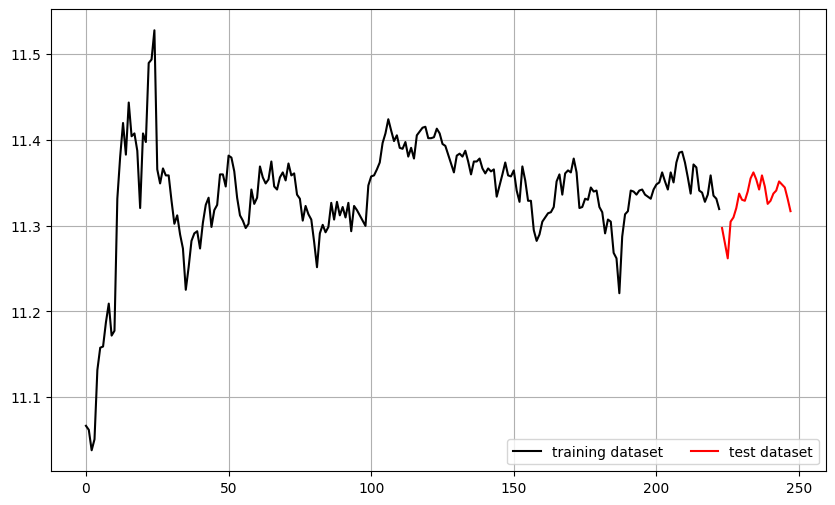

In [18]:
print(k_train_data.shape)
print(k_test_data.shape)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(k_train_data, color='black', label='training dataset')
plt.plot(k_test_data, color='red', label='test dataset')
plt.legend(ncol=2, loc='lower right')
plt.show()

- 일단 시각화를 통해 그래프의 형태를 확인하였습니다.

## STEP 5 : 적정 ARIMA 모수 찾기

### ACF, PACF 그래프 구하여 p, q값 구하기
  
  
  
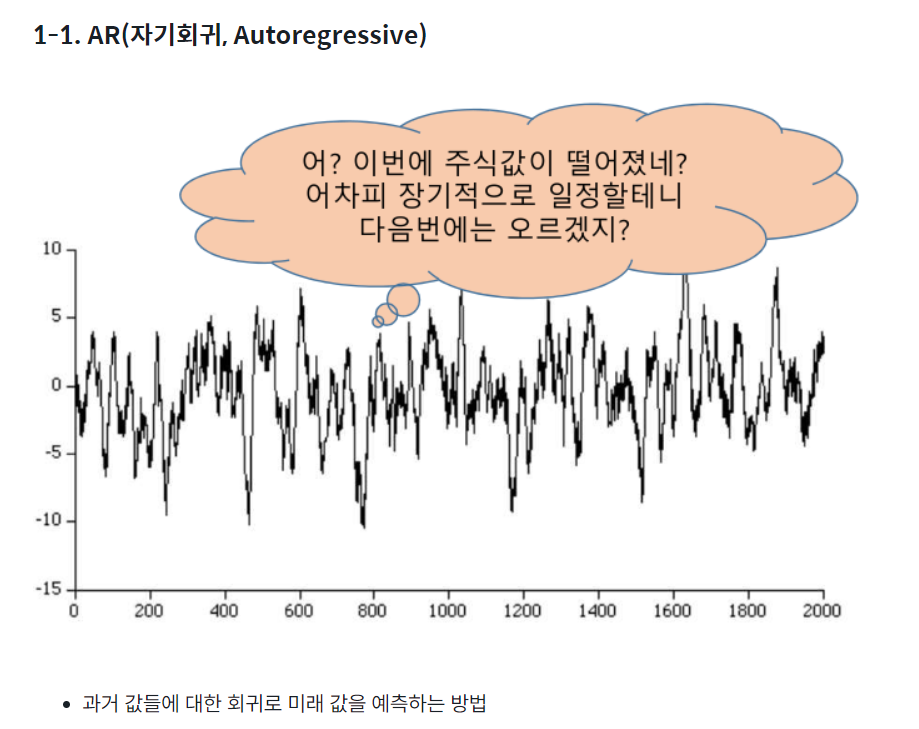
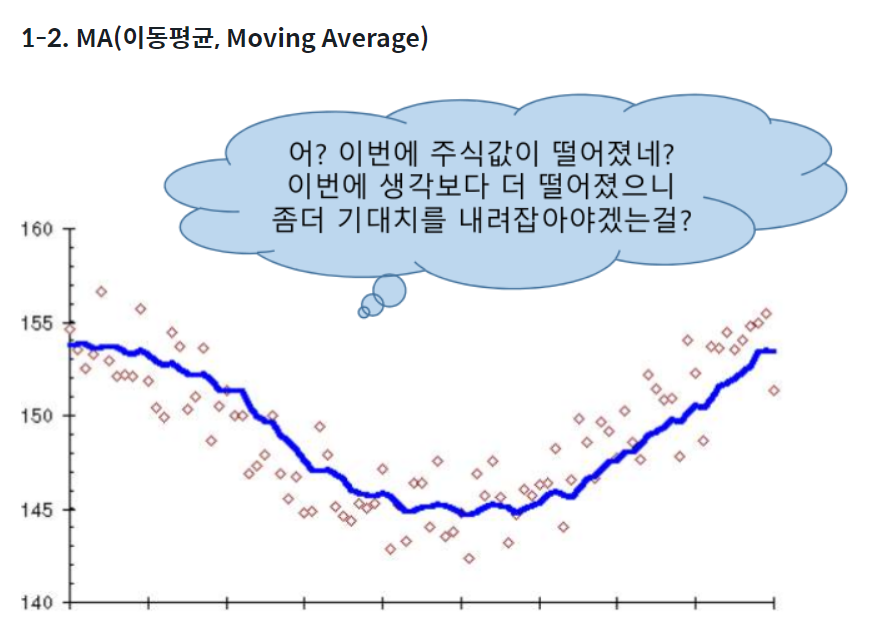

- p,q 값을 구하기 위해선 statsmodels 모듈 안에 있는 plot_acf, plot_pacf를 사용하면 간편하게 그려낼 수 있습니다. 이를 통해 한번 구해보도록 하겠습니다.

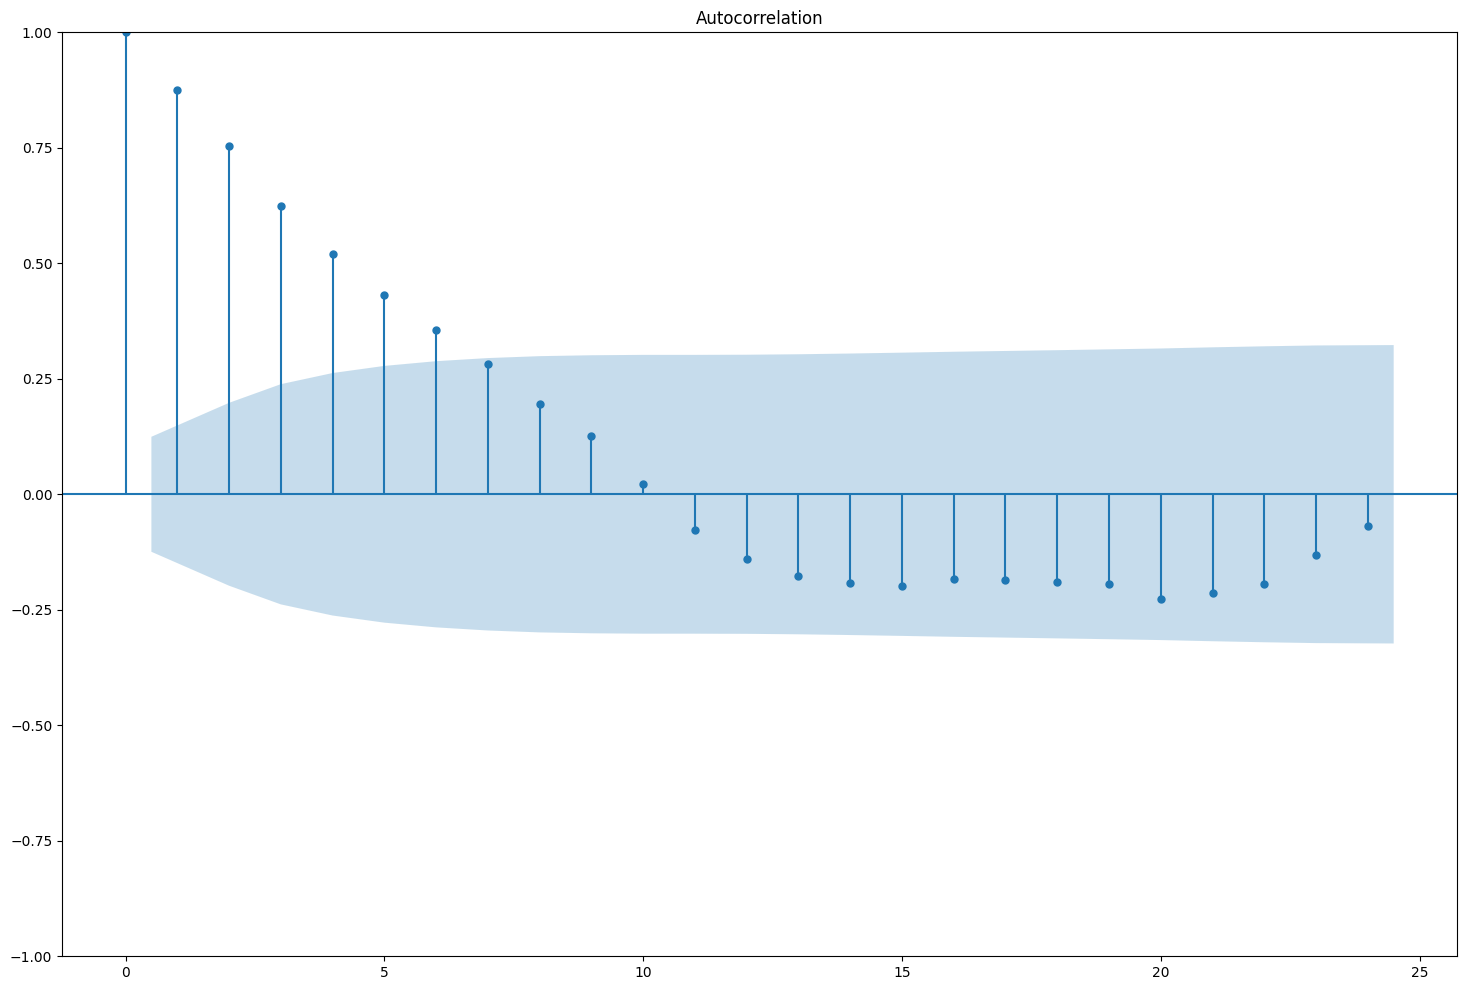

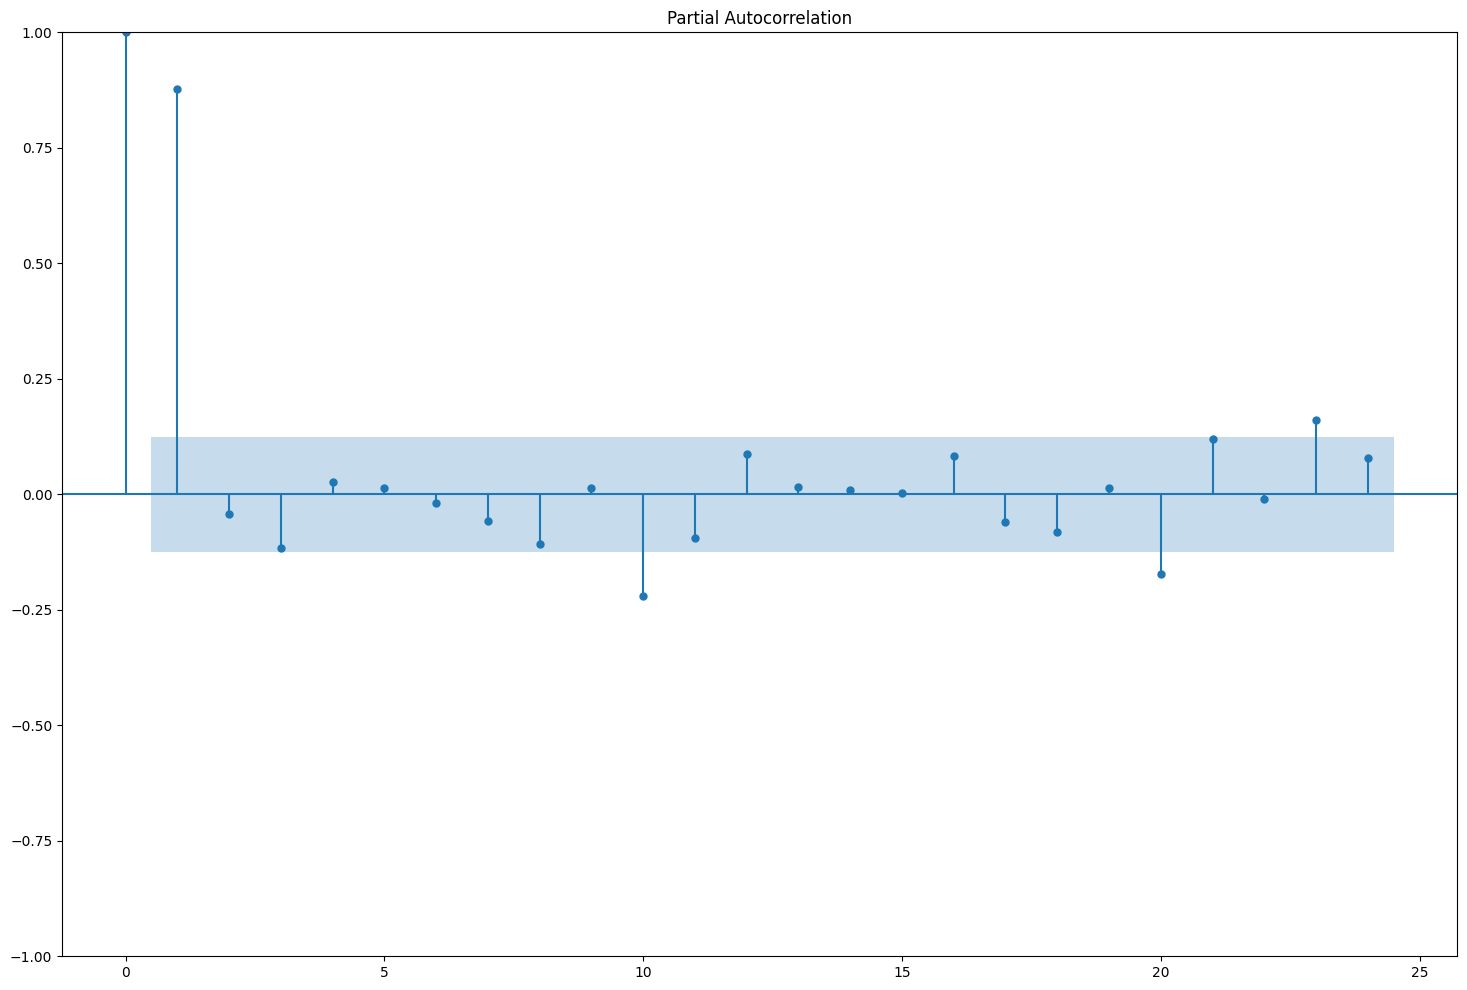

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kia_log, alpha=0.05)
plot_pacf(kia_log, alpha=0.05)
plt.show()

- 현재 그래프를 보아하니 ACF의 점들이 6까지 신뢰구간을 벗어나 있군요. 이럴때는 MR(6) 모형으로 보여집니다. 그러니 q값을 6으로 하는게 좋을듯 보입니다.
  
  
- 그에 비해 p값은 1이 적당해보입니다만 0도 시도해볼 수 있을 것 같습니다.

### 차분 안정성 구하기

Results of ADF test
Test Statistic                  -4.555266
p-value                          0.000156
#Lags Used                       8.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


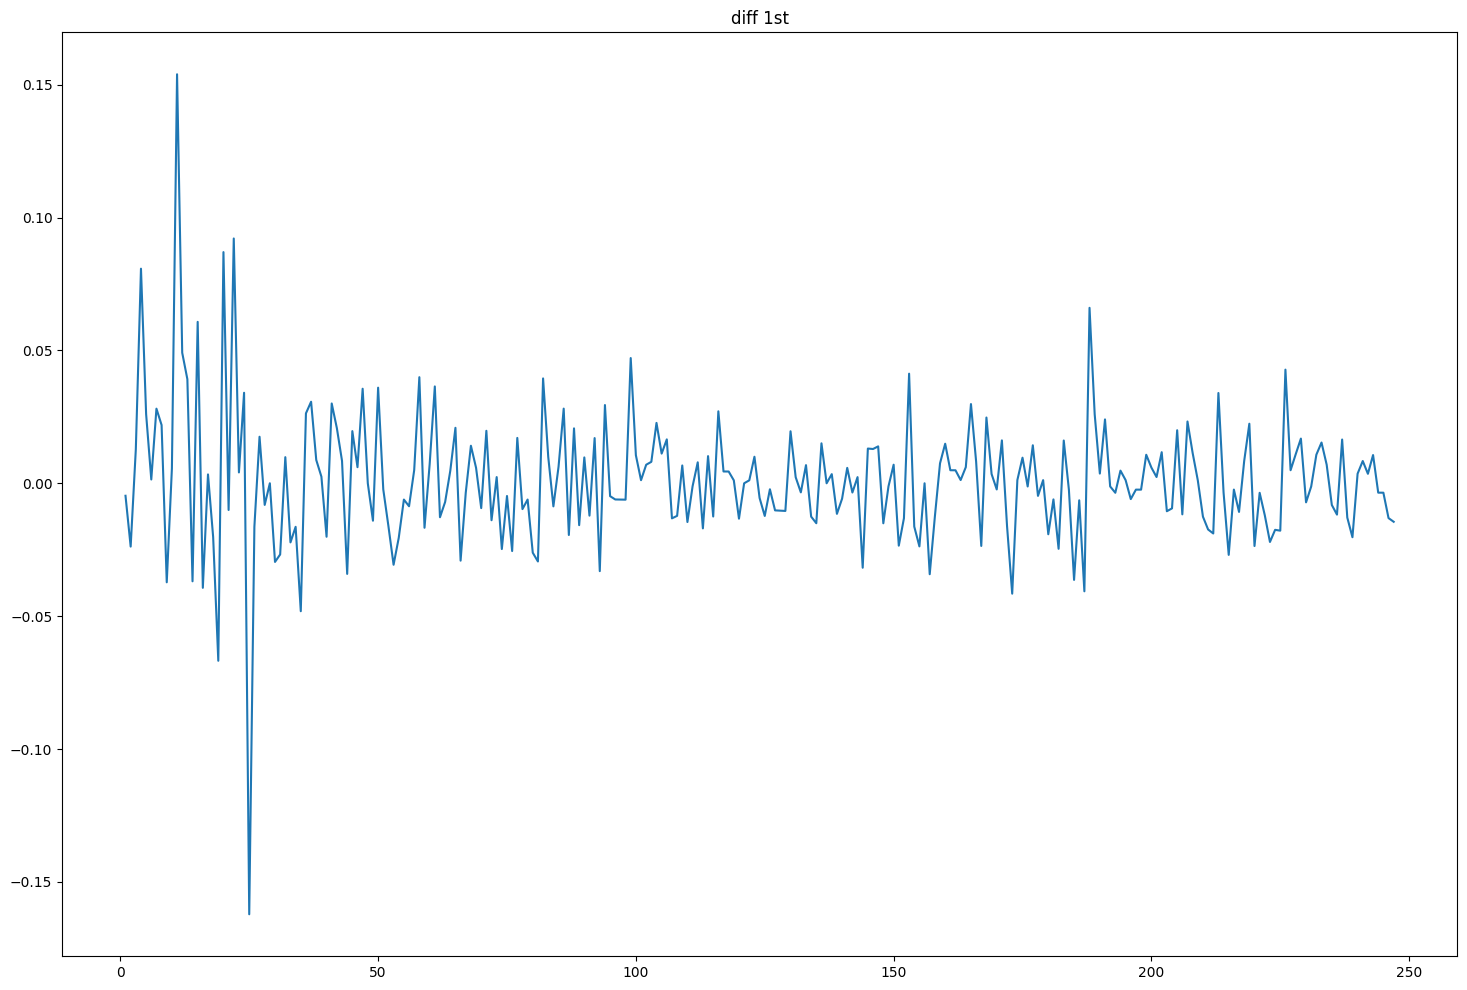

In [20]:
k_diff_1 = kia_log.diff(periods=1).iloc[1:]
k_diff_1.plot(title='diff 1st')

augmented_dickey_fuller_test(k_diff_1)

- p-value 값이 0.000156으로 안정적인 값을 띄는군요.
- 통계적으로 유의미한 값임이 확인되었습니다.
- 차분을 1번 했으니 d값은 1이 적당하겠군요.

## STEP 6 : ARIMA 모델 훈련과 테스트

- 다시 한번 p, d, q값에 대해 알아보겠습니다.
> 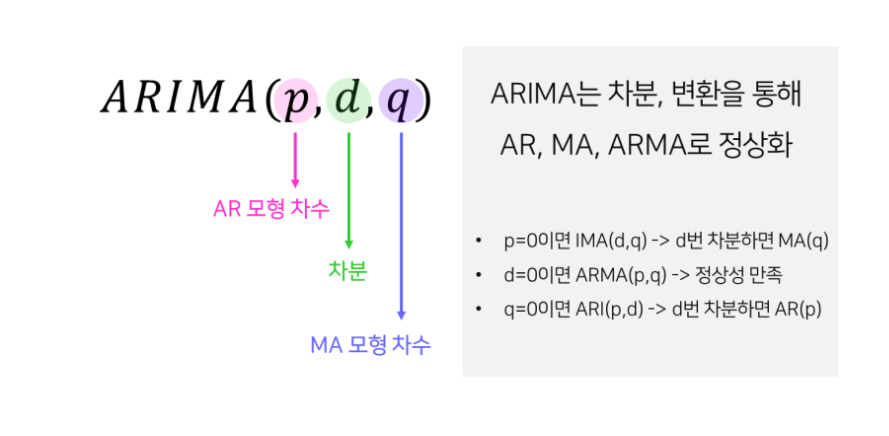

### ARIMA 모델 빌드와 훈련

In [21]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(k_train_data, order = (1,1,3))

fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 491.766
Date:                Fri, 30 Sep 2022   AIC                           -973.532
Time:                        16:25:58   BIC                           -956.519
Sample:                             0   HQIC                          -966.663
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4699      0.270     -1.741      0.082      -0.999       0.059
ma.L1          0.4363      0.263      1.656      0.098      -0.080       0.953
ma.L2         -0.0031      0.055     -0.056      0.9

- ARIMA 모델을 통해 값들을 확인해 보았습니다.
  
  
  
- ARIMA(order = (p,d,q)) 순서 입니다.
- 처음엔 (1, 1, 6) 모델로 확인하였으나 P>|z|(p-value)가 유의미한 값을 띄지 않기에 유의미한 값을 보이는 (1,1,3)을 채택하였습니다.
---
  
  
- 이젠 forecast 함수를 이용해 예측하고 시각화해보도록 하겠습니다.

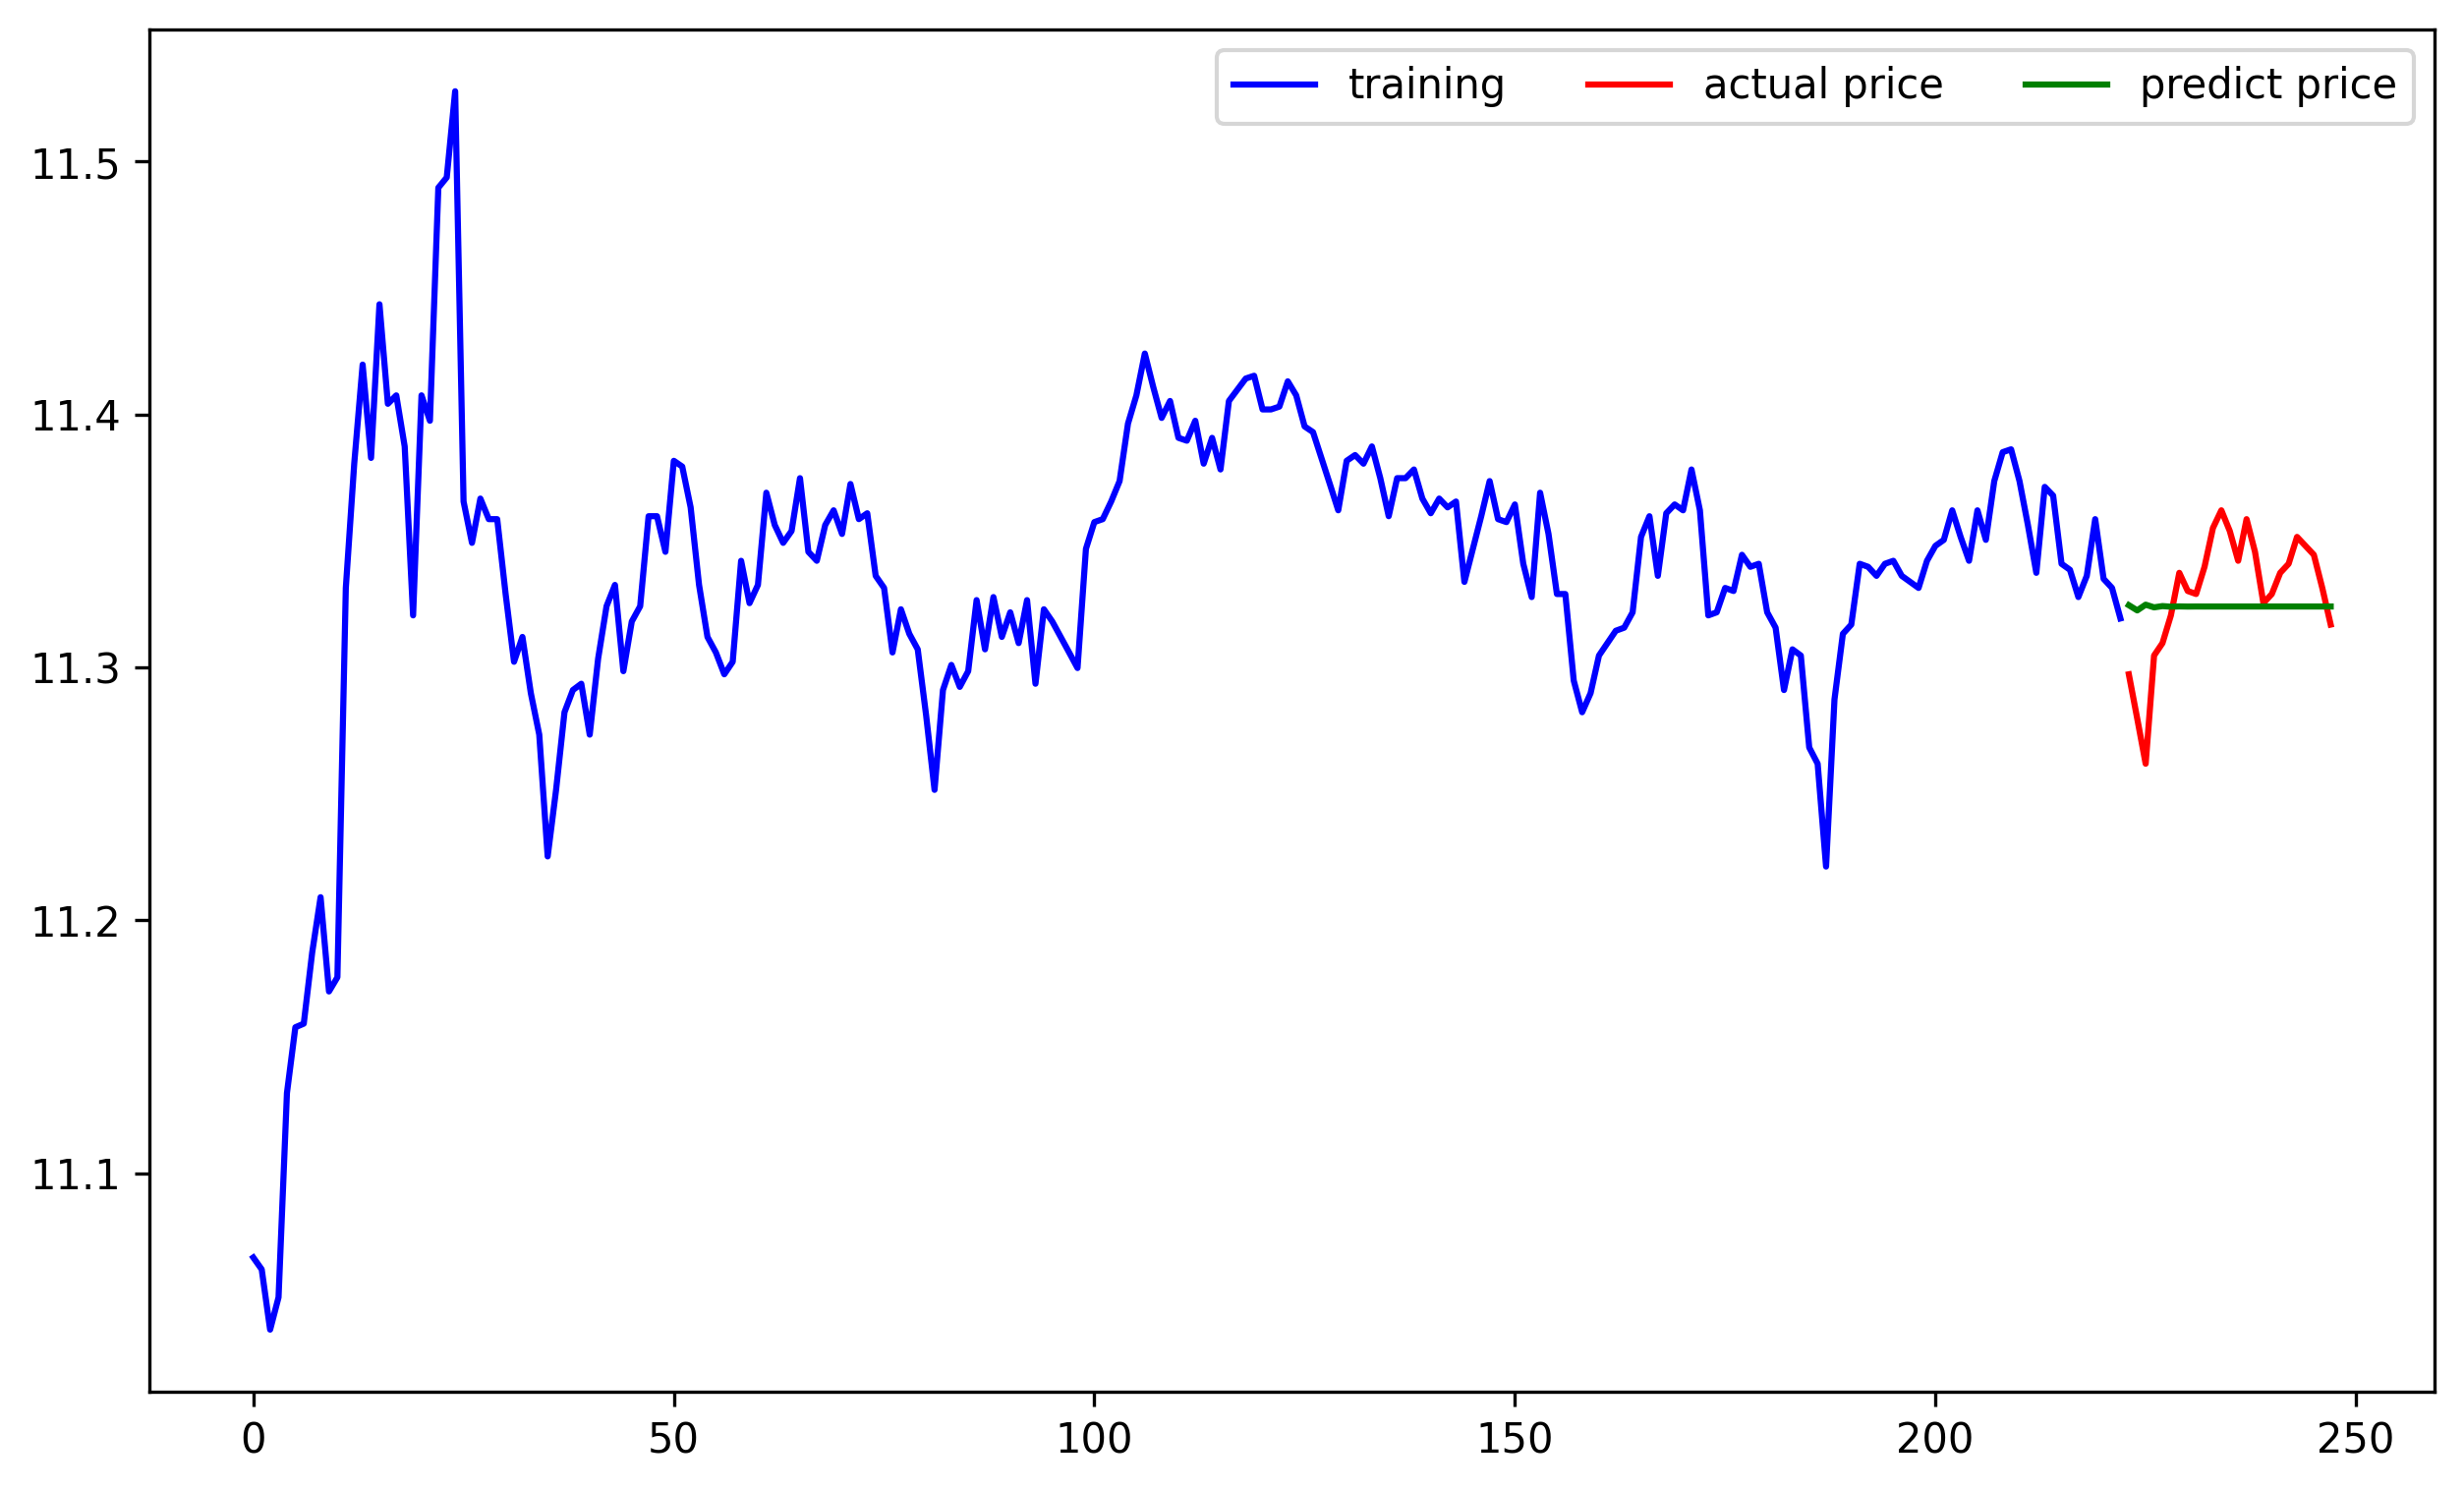

In [22]:
fc = fitted_m.forecast(len(k_test_data), alpha=0.05)

fc = np.array(fc)

fc_series = pd.Series(fc, index=k_test_data.index)

plt.figure(figsize=(10,6), dpi= 300)
plt.plot(k_train_data, color='blue', label = 'training')
plt.plot(k_test_data, color='red', label = 'actual price')
plt.plot(fc_series, color='green', label = 'predict price')
plt.legend(ncol=3, loc='best')
plt.show()

- 예측 그래프가 시작과 끝을 얼추 비슷하게 예측하고 있군요.
- 나름 의미가 있어보입니다.

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(k_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(k_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(k_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(k_test_data))/np.abs(np.exp(k_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4146791.467211165
MAE:  1678.3562595597514
RMSE:  2036.367223074258
MAPE: 2.02%


- MAPE 값이 2.02% 로 예측한 값이 유의미하다는것을 알게되었습니다.

## __2. 프로젝트 : 주식 예측에 도전해보자! - 한화솔루션 (009830.KS)__

## STEP 1 : 시계열 데이터 준비

In [24]:
hansol_df = pd.read_csv('./data/hansol_01.csv')

In [25]:
hansol_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,47013.296875,48031.113281,45801.617188,47691.839844,47691.839844,4531642
1,2021-01-05,47837.242188,53604.855469,47158.699219,52247.769531,52247.769531,14559485
2,2021-01-06,52247.769531,53314.050781,49824.402344,51569.226563,51569.226563,8608777
3,2021-01-07,55155.808594,56415.957031,52829.375000,53701.789063,53701.789063,9343121
4,2021-01-08,55252.742188,55931.285156,53798.722656,54961.937500,54961.937500,5858843


In [26]:
hansol_ts = hansol_df['Close']

- 똑같이 데이터를 확인해주고 Close 컬럼만 따로 분리해주도록 하겠습니다.

## STEP 2 : 각종 전처리 수행

In [27]:
hansol_ts.isna().sum()

0

- 이 데이터도 결측치가 0이군요. 좋습니다.

## STEP 3 : 시계열 안정성 분석

### 정성적 데이터 분석

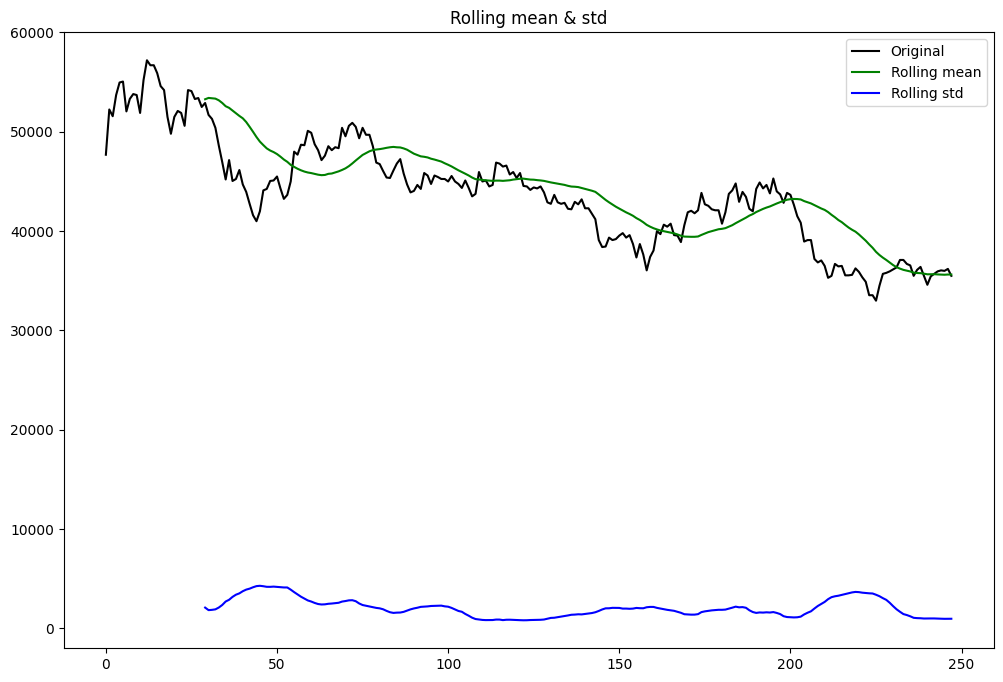

In [28]:
plot_rolling_statistics(hansol_ts)

In [29]:
hansol_log = np.log1p(hansol_ts)

- 이 데이터도 일정하지 않은 변동성을 보이는것처럼 보입니다. log화 하여 안정성을 획득해보겠습니다.

### 정량적 데이터 분석

In [30]:
augmented_dickey_fuller_test(hansol_log)

Results of ADF test
Test Statistic                  -1.108349
p-value                          0.711731
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- log화를 했는데도 p-value값이 0.711로 유의미하지 않습니다.
- 계절성부터 확인해보겠습니다.

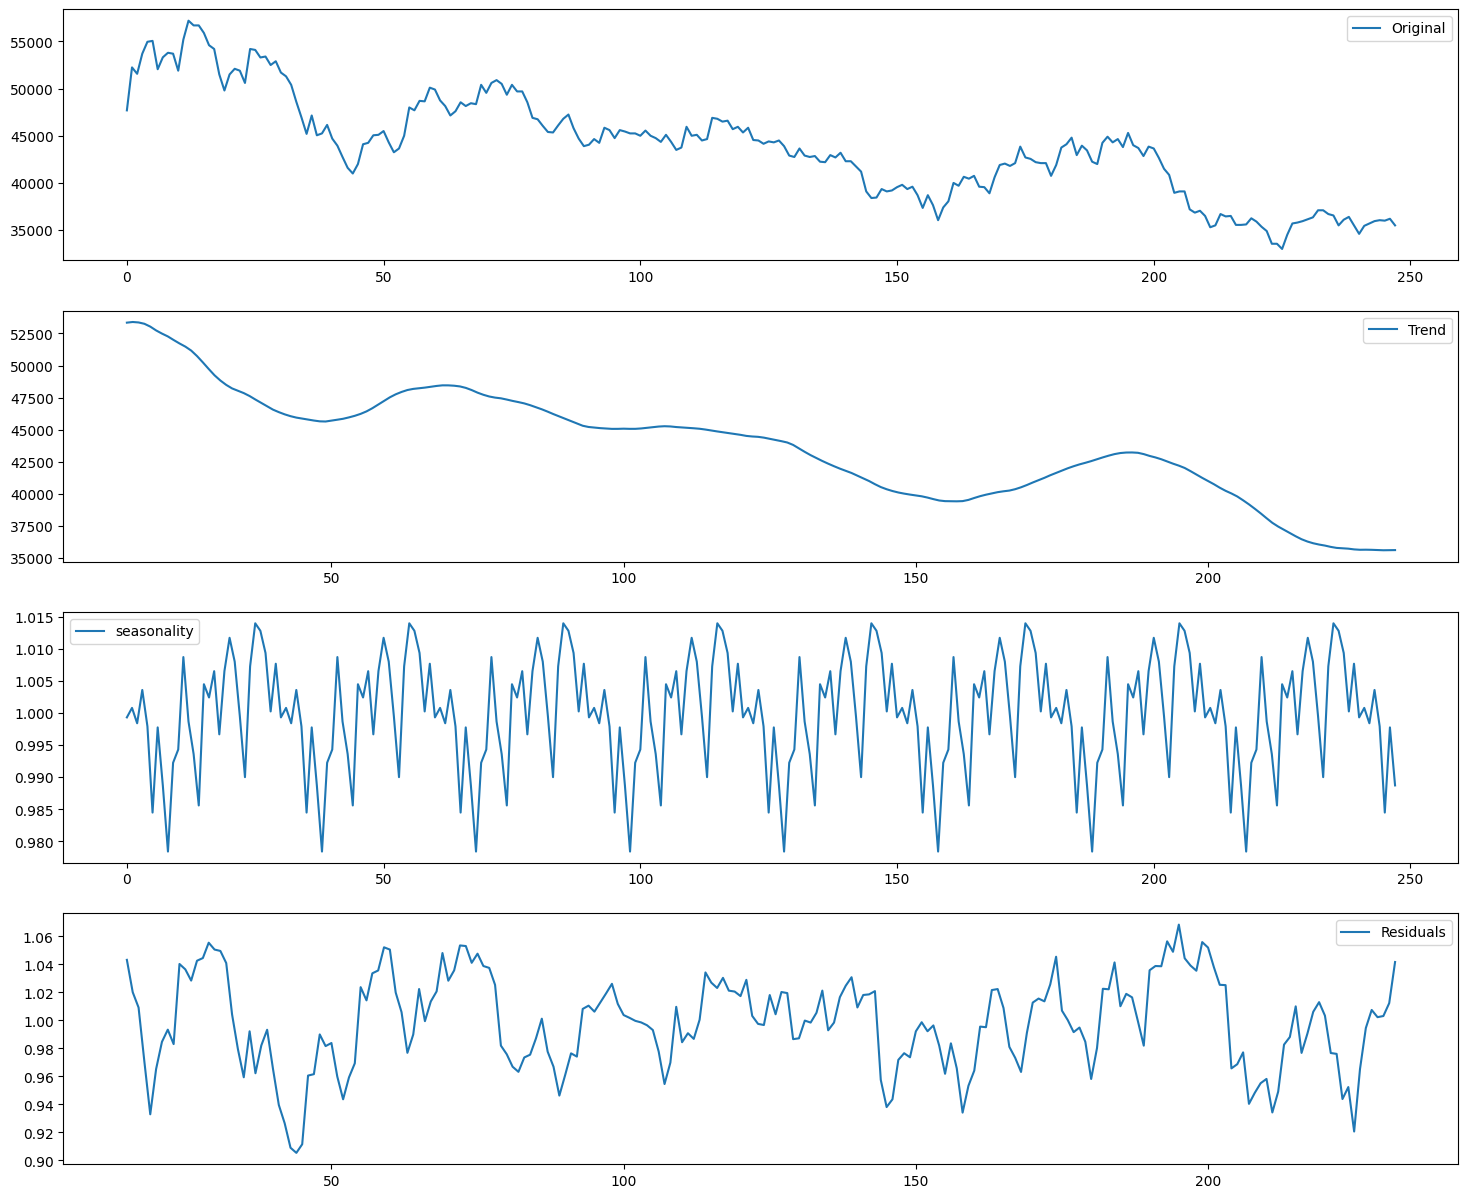

In [31]:
decomposition = seasonal_decompose(hansol_ts, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams['figure.figsize'] = (18, 15)
plt.subplot(411)
plt.plot(hansol_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

- 계절성을 띄는게 보이는군요. residual 확인 후 차분하도록 하겠습니다.

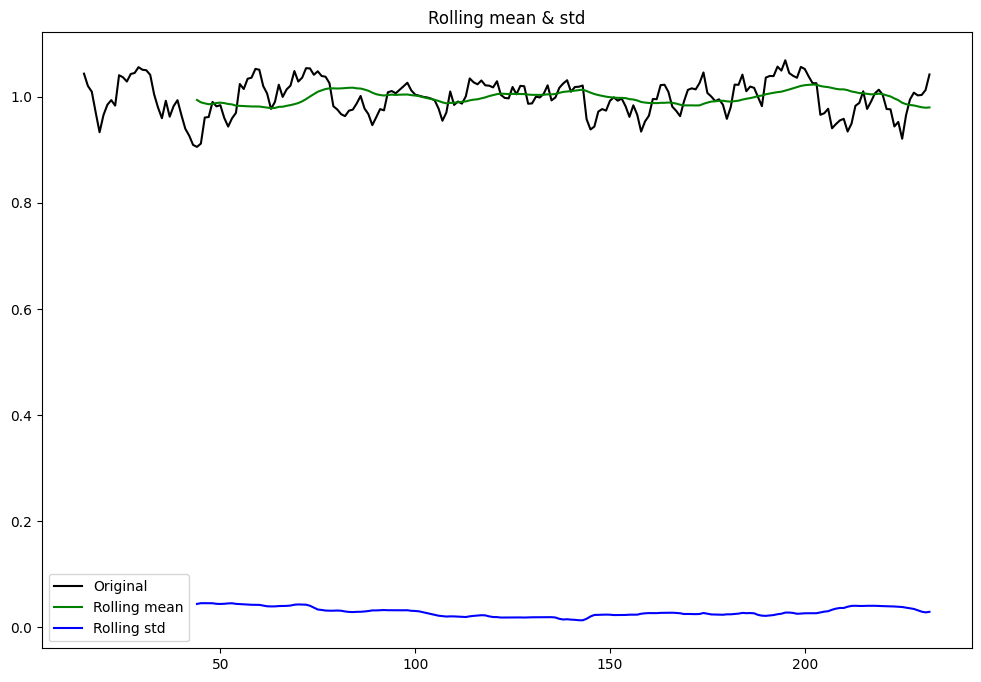

In [32]:
plt.rcParams["figure.figsize"] = (18,12)
plot_rolling_statistics(residual)

In [33]:
residual.isna().sum()

30

In [34]:
len(residual)

248

In [35]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of ADF test
Test Statistic                  -4.715022
p-value                          0.000079
#Lags Used                       0.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


- p-value값이 0.000079로 아주 안정적이군요. 진행해도 괜찮겠습니다.

## STEP 4 : 학습, 테스트 데이터셋 생성

In [36]:
h_train_data, h_test_data = hansol_log[:int(len(hansol_log)*0.9)], hansol_log[int(len(hansol_log)*0.9):]

(223,)
(25,)


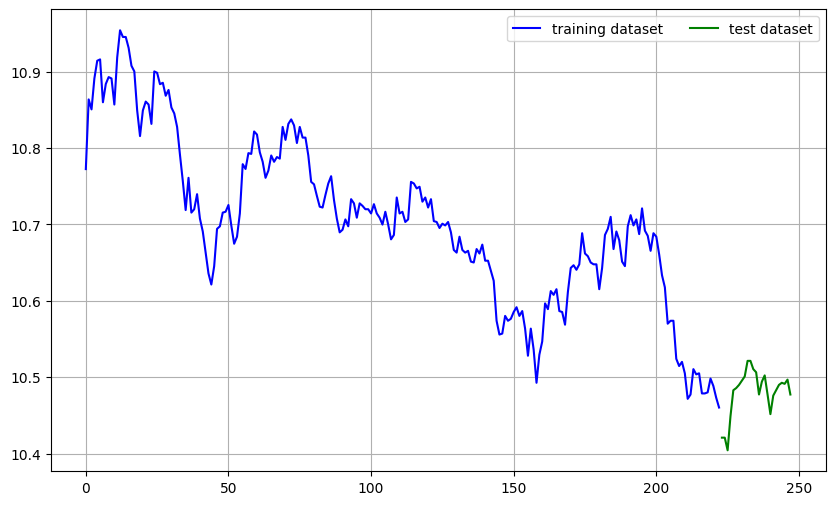

In [37]:
print(h_train_data.shape)
print(h_test_data.shape)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(h_train_data, color='blue', label='training dataset')
plt.plot(h_test_data, color='green', label='test dataset')
plt.legend(ncol=2, loc='best')
plt.show()

- 마찬가지로 train 90%, test 10%의 비율로 데이터셋을 나누었습니다.

## STEP 5 : 적정 ARIMA 모수 찾기

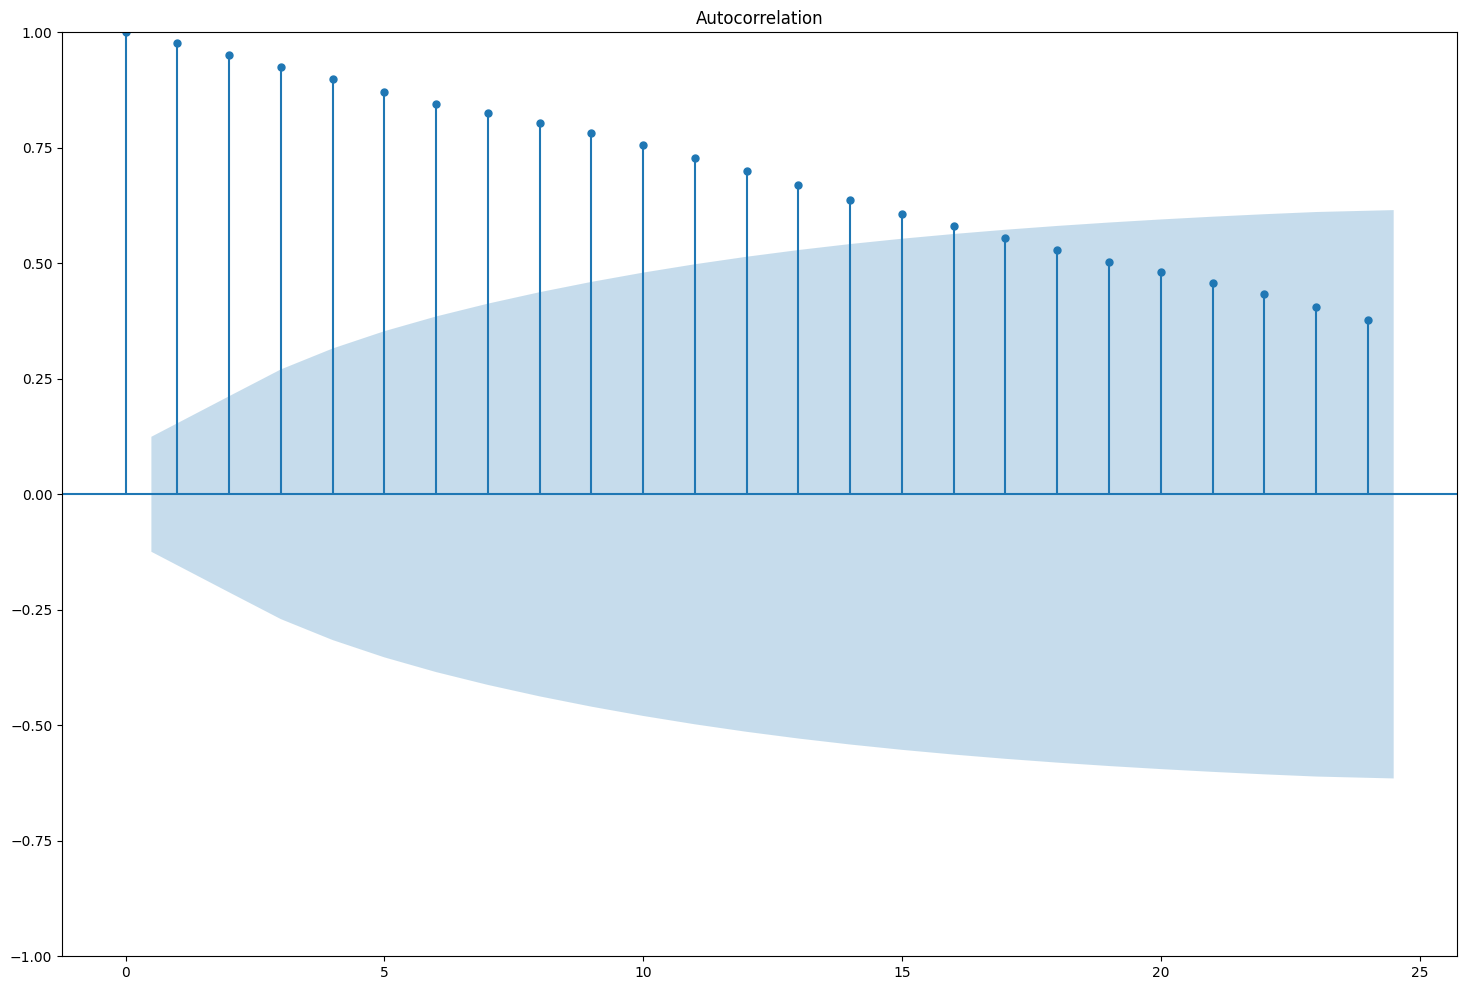

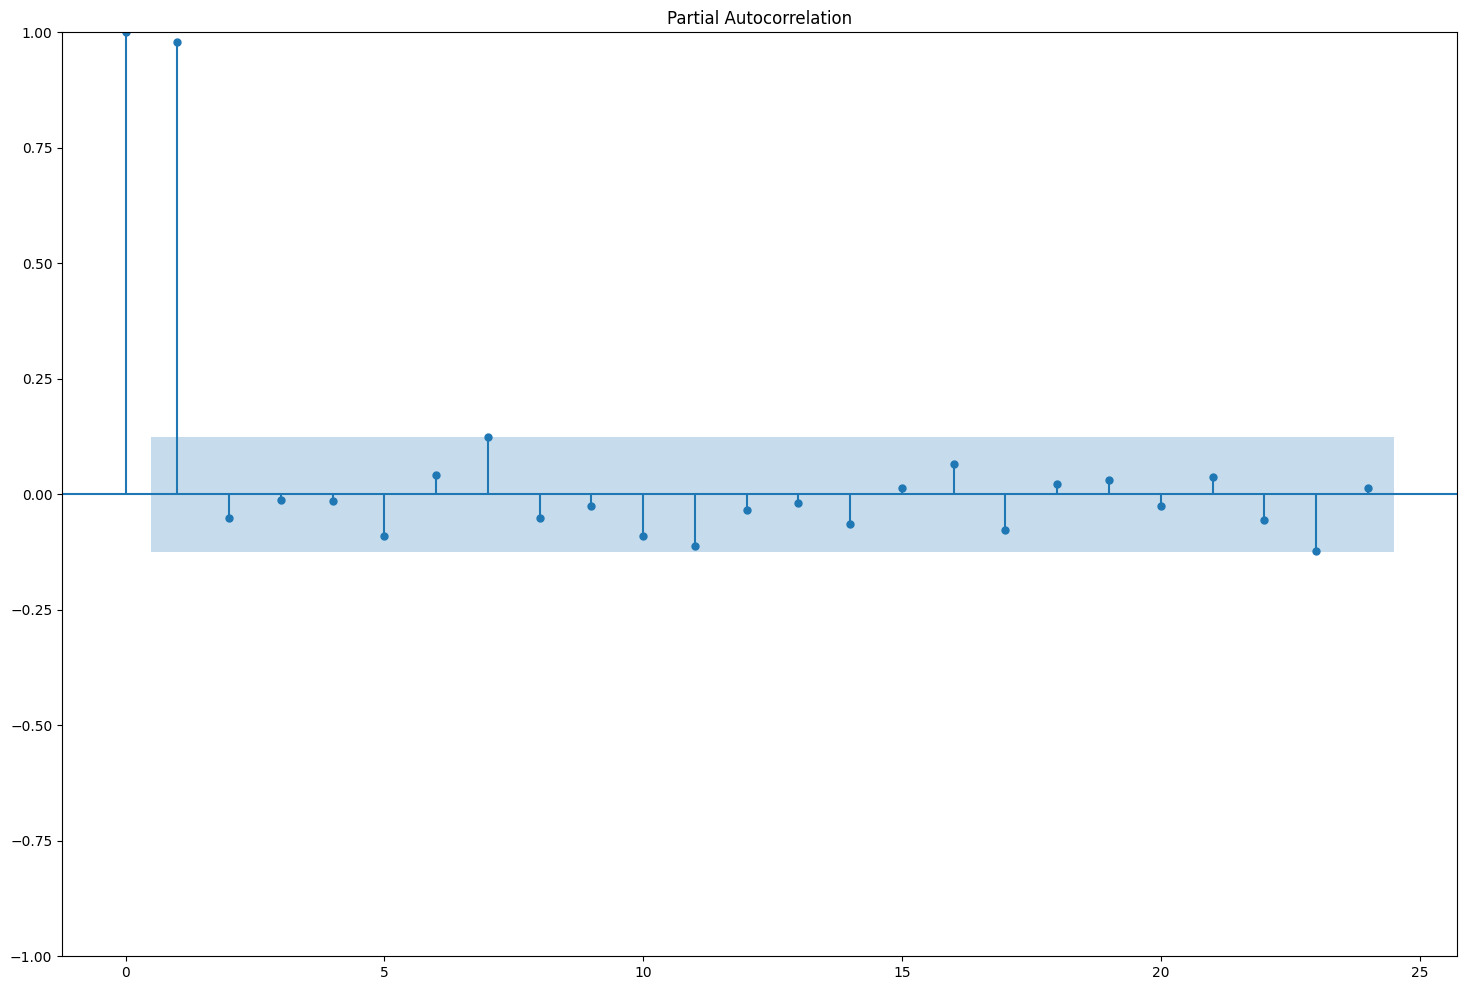

In [38]:
plot_acf(hansol_log, alpha = 0.05) # alpha = 0.05 == p-value를 0.05로 설정한다는것과 같다.
plot_pacf(hansol_log, alpha = 0.05) 
plt.show()

- 위 그래프에서 MR(16), AR(1) 모형인것으로 보입니다.
- 따라서, p = 1, q = 16이 좋아보입니다.

#### 차분 안정성 구하기

Results of ADF test
Test Statistic                -1.601942e+01
p-value                        6.228340e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


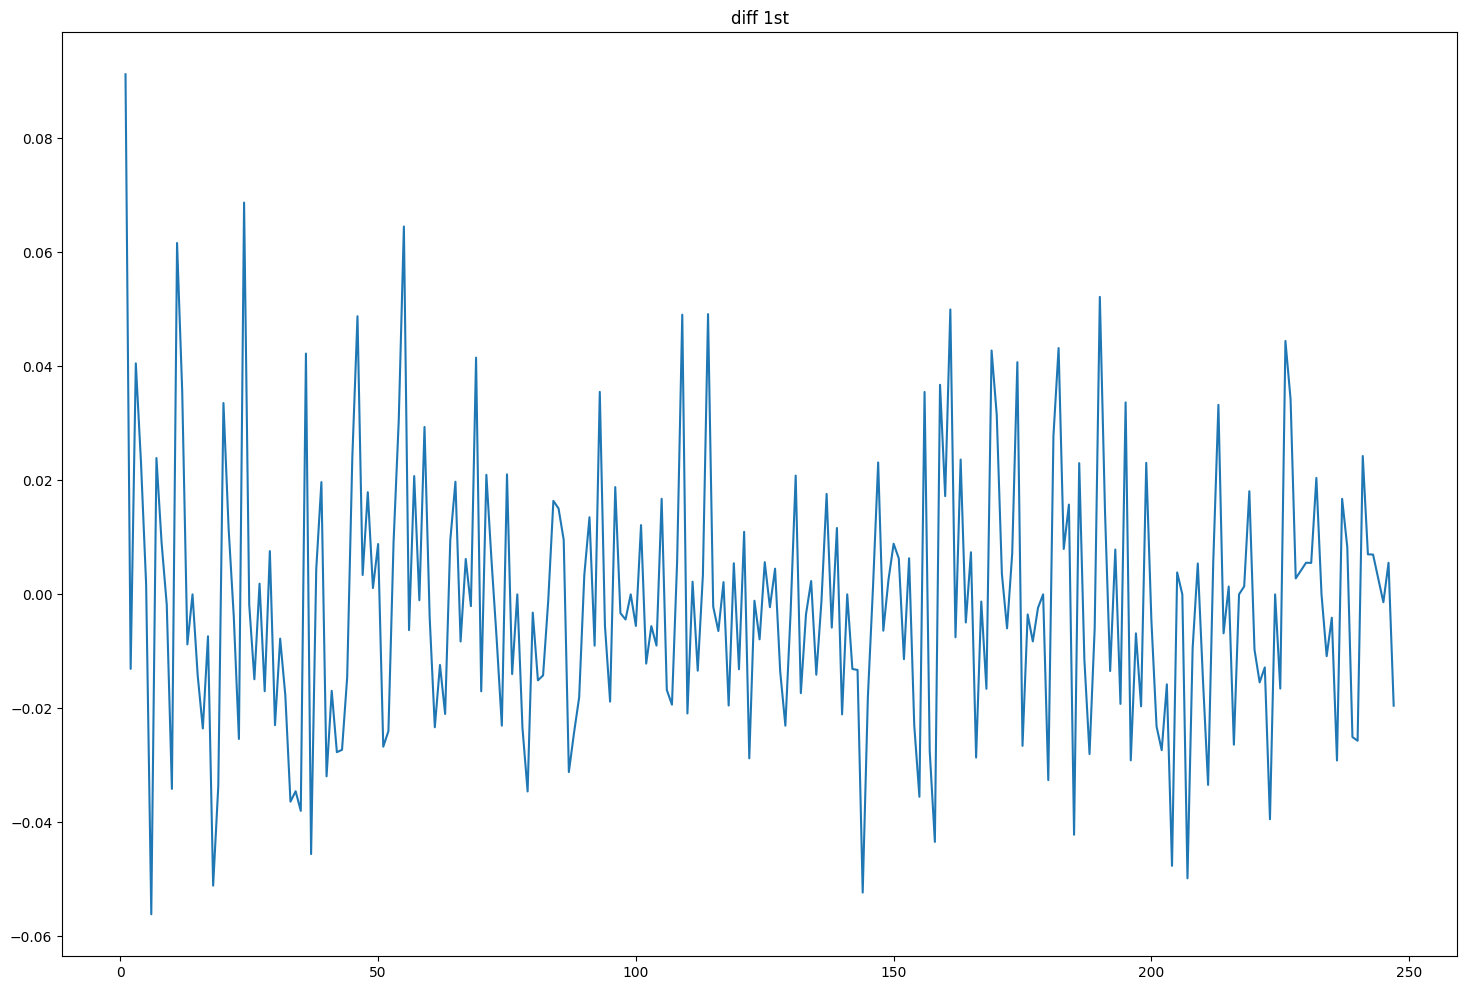

In [39]:
h_diff_1 = hansol_log.diff(periods=1).iloc[1:]
h_diff_1.plot(title='diff 1st')

augmented_dickey_fuller_test(h_diff_1)

- 1차 차분을 하였더니 안정성을 띄는것을 확인하였습니다.

## STEP 6 : ARIMA 모델 훈련과 테스트

In [40]:
model = ARIMA(h_train_data, order = (0,1,6))

fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(0, 1, 6)   Log Likelihood                 520.790
Date:                Fri, 30 Sep 2022   AIC                          -1027.579
Time:                        16:26:01   BIC                          -1003.760
Sample:                             0   HQIC                         -1017.963
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0025      0.071     -0.035      0.972      -0.142       0.137
ma.L2          0.0362      0.070      0.520      0.603      -0.100       0.173
ma.L3          0.0265      0.069      0.386      0.6

- 이유는 정확하게 모르겠으나 MR(16) 모형이었던 그래프에서 통계적으로 유의미한 값을 보이지않아 ARIMA 통계상 보인 유의미한 값 q = 6, p = 0을 대입하였습니다.
- 현재 우리의 모델이 통계적으로 유의미한 값을 띄는것을 확인할 수 있습니다.

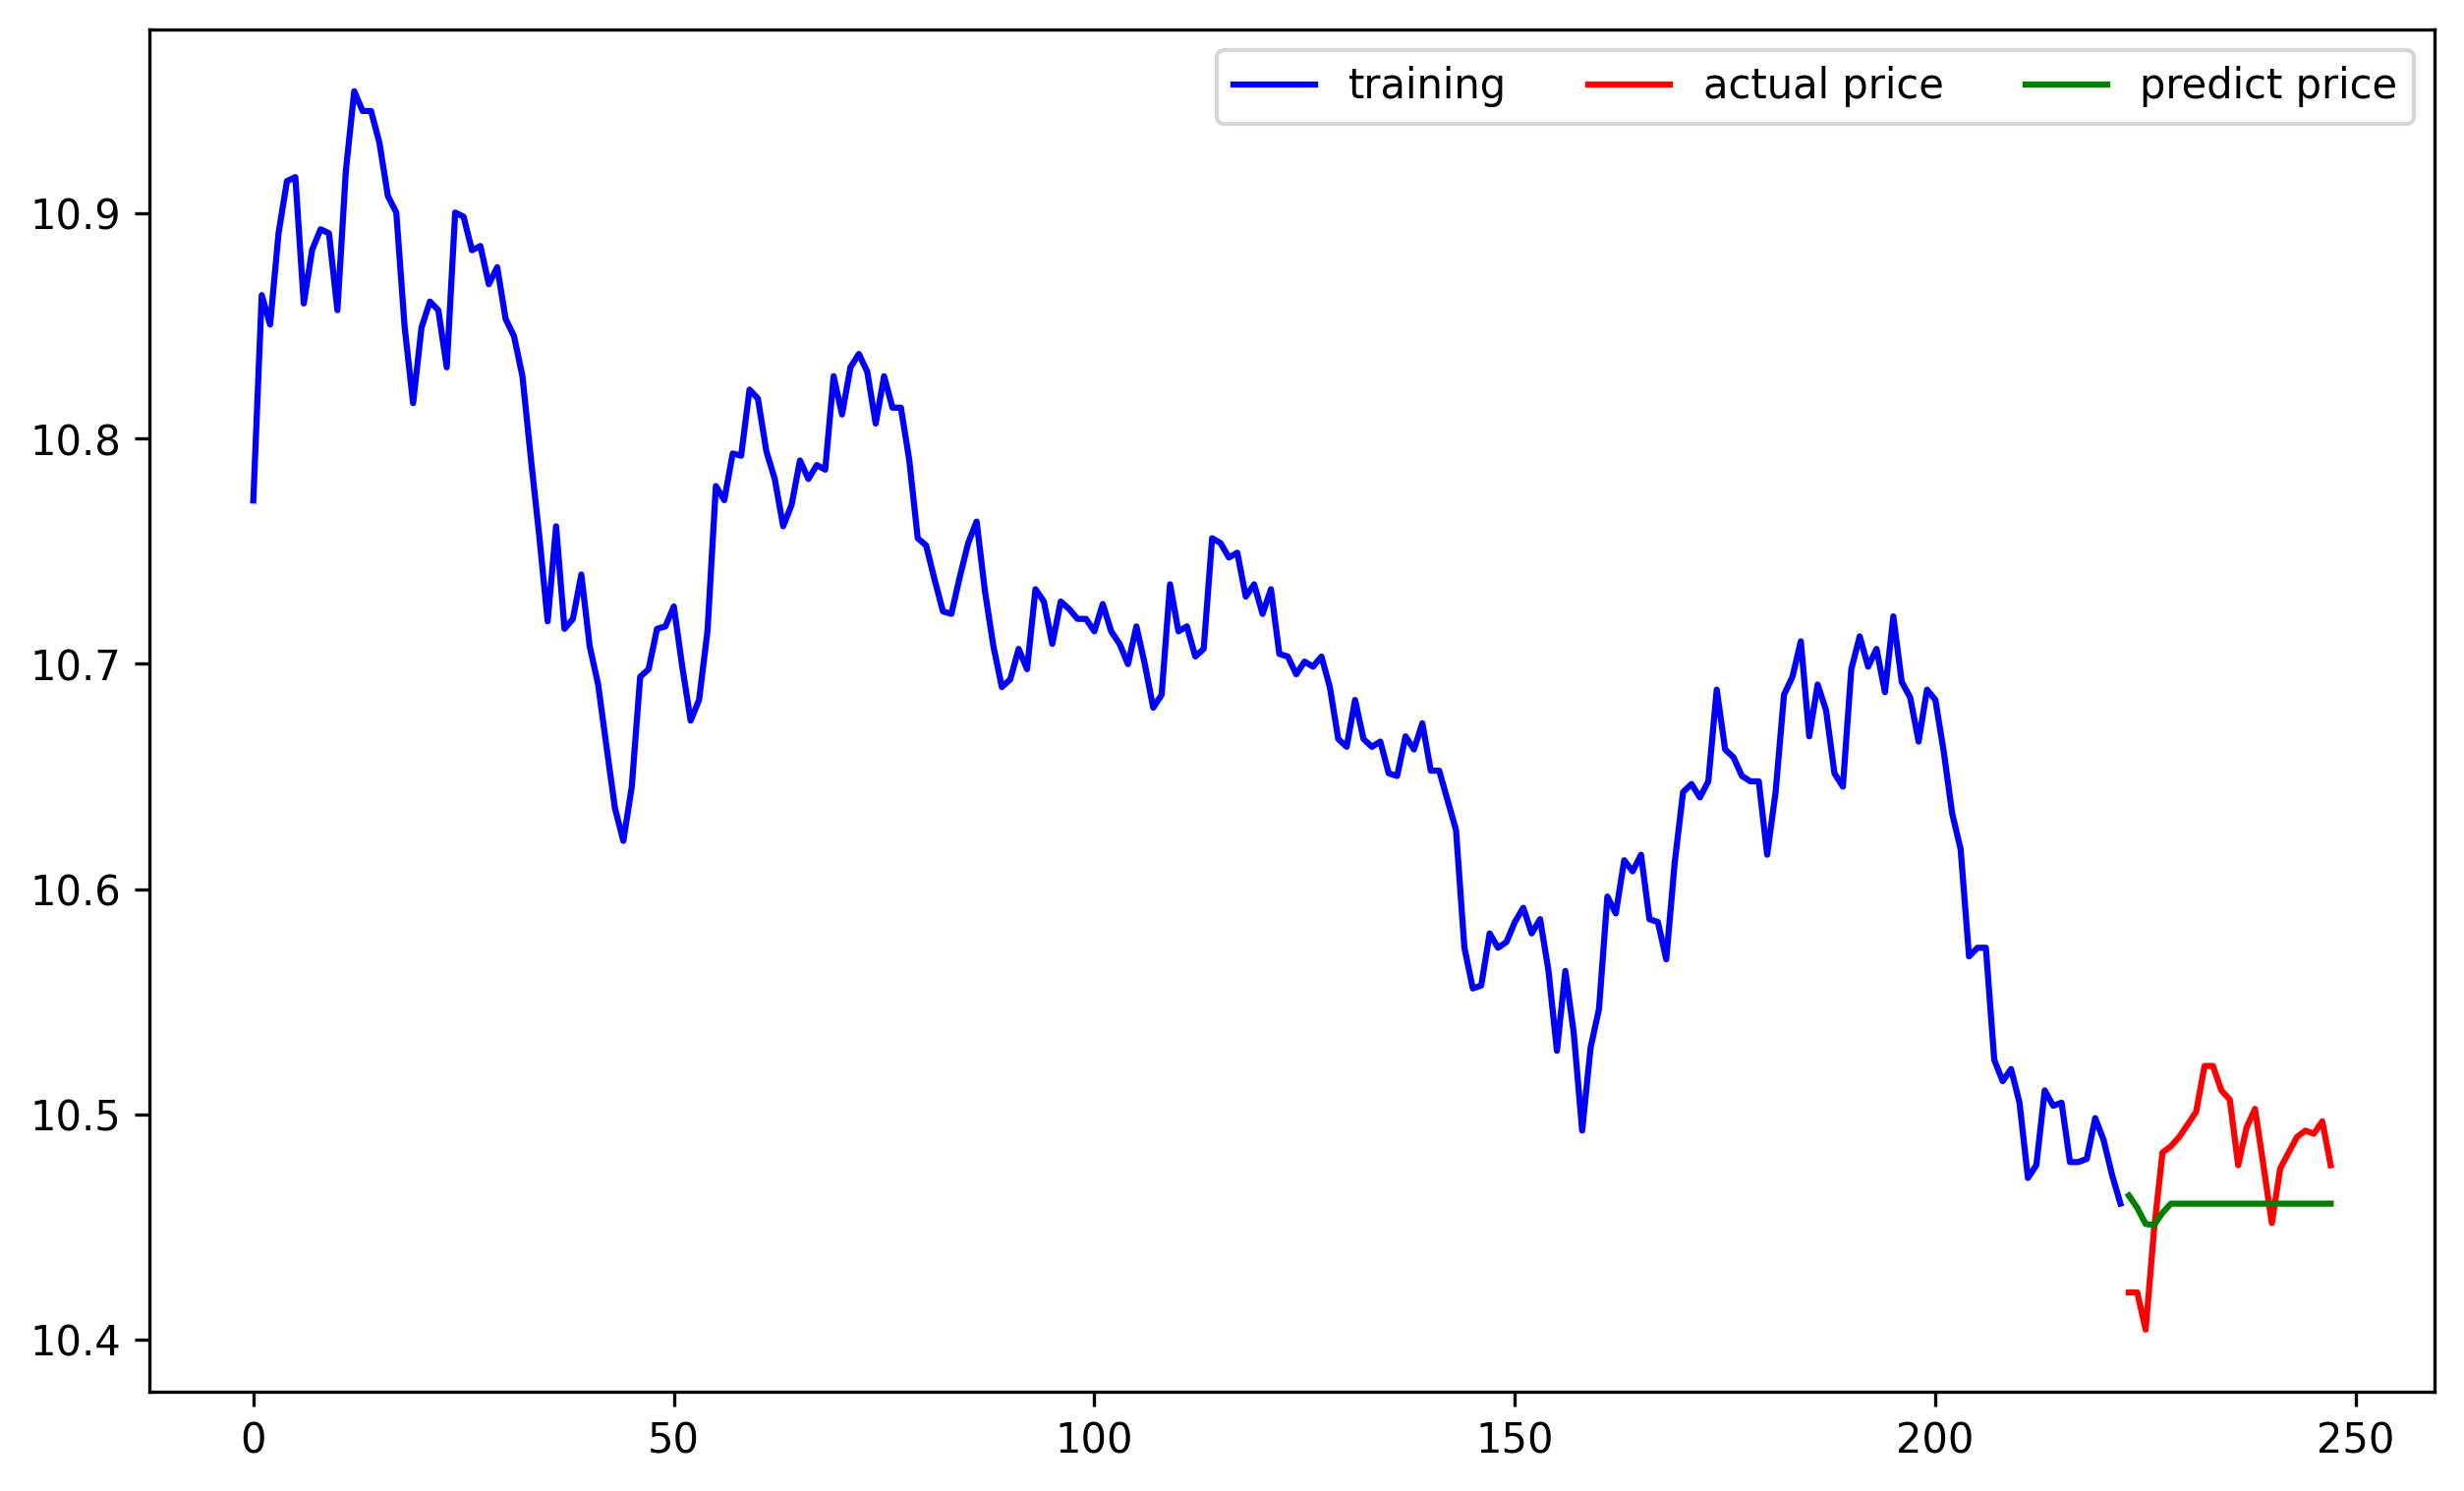

In [41]:
fc = fitted_m.forecast(len(h_test_data), alpha=0.05)

fc_series = pd.Series(fc, index=h_test_data.index)

plt.figure(figsize=(10,6), dpi= 300)
plt.plot(h_train_data, color='blue', label = 'training')
plt.plot(h_test_data, color='red', label = 'actual price')
plt.plot(fc_series, color='green', label = 'predict price')
plt.legend(ncol=3, loc='best')
plt.show()

- 애매하기는 하지만 어느정도 시작과 끝을 예측하는 모습을 볼수 있습니다. 이정도면 괜찮은것 같군요.

In [42]:
mse = mean_squared_error(np.exp(h_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(h_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(h_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(h_test_data))/np.abs(np.exp(h_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1584314.3367424589
MAE:  1144.702774306755
RMSE:  1258.6954900779056
MAPE: 3.20%


- MAPE 점수가 3.21%로 유의미한 값이 나왔습니다.
- 현재 모델이 의미가 있어보입니다.

## __3. 프로젝트 : 주식 예측에 도전해보자! - 만도 (204320.KS)__

## STEP 1 : 시계열 데이터 준비

In [43]:
mando_df = pd.read_csv('./data/mando_01.csv')

In [44]:
mando_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,59100.0,63500.0,58200.0,62700.0,61905.074219,1446315
1,2021-01-05,62600.0,68800.0,62200.0,66700.0,65854.359375,1605512
2,2021-01-06,67000.0,67500.0,65400.0,65800.0,64965.769531,843863
3,2021-01-07,66100.0,71300.0,66000.0,67700.0,66841.679688,1248859
4,2021-01-08,74200.0,87000.0,70200.0,77400.0,76418.703125,5970009


In [45]:
mando_ts = mando_df['Close']

- 위와 같이 데이터를 불러오고 Close 컬럼만 분리하여 series 로 만들었습니다.

## STEP 2 : 각종 전처리 수행

In [46]:
mando_ts.isna().sum()

0

- 이 데이터도 결측치가 0이군요.

## STEP 3 : 시계열 안정성 분석

#### 정성적 데이터 분석

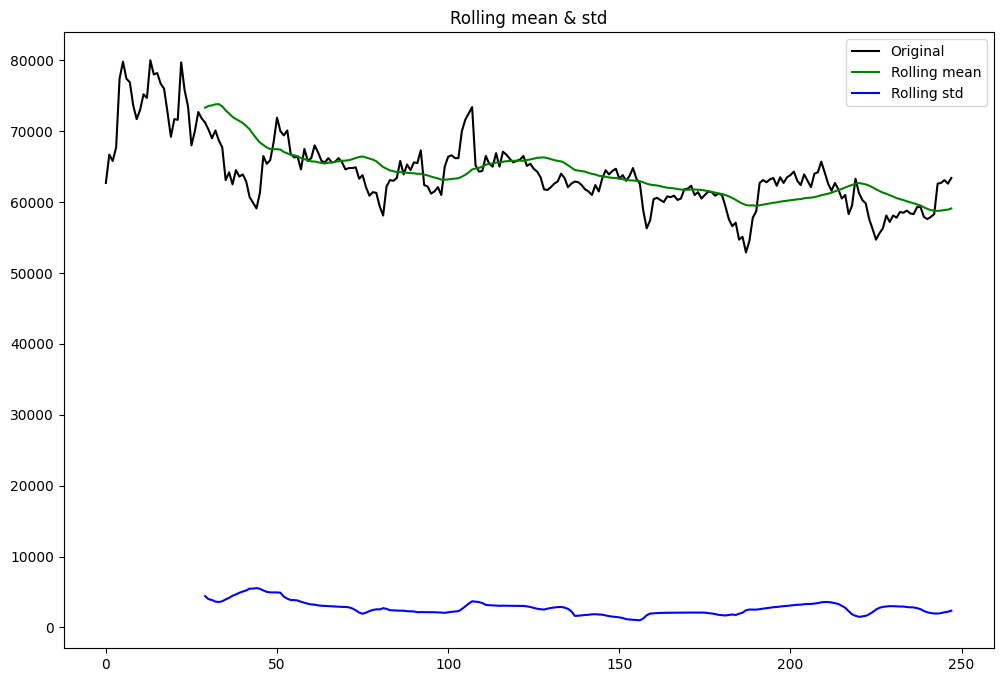

In [47]:
plot_rolling_statistics(mando_ts)

In [48]:
mando_log = np.log1p(mando_ts)

- 위와 같이 데이터의 변동폭이 일정하지 않아보이기때문에 log화 하여주었습니다.

### 정량적 데이터 분석

In [49]:
augmented_dickey_fuller_test(mando_log)

Results of ADF test
Test Statistic                  -2.987266
p-value                          0.036101
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- p-value 값이 0.036로 값은 유의미해보이지만.. 계절성도 확인을 해봐야겠습니다.

### 시계열 분해

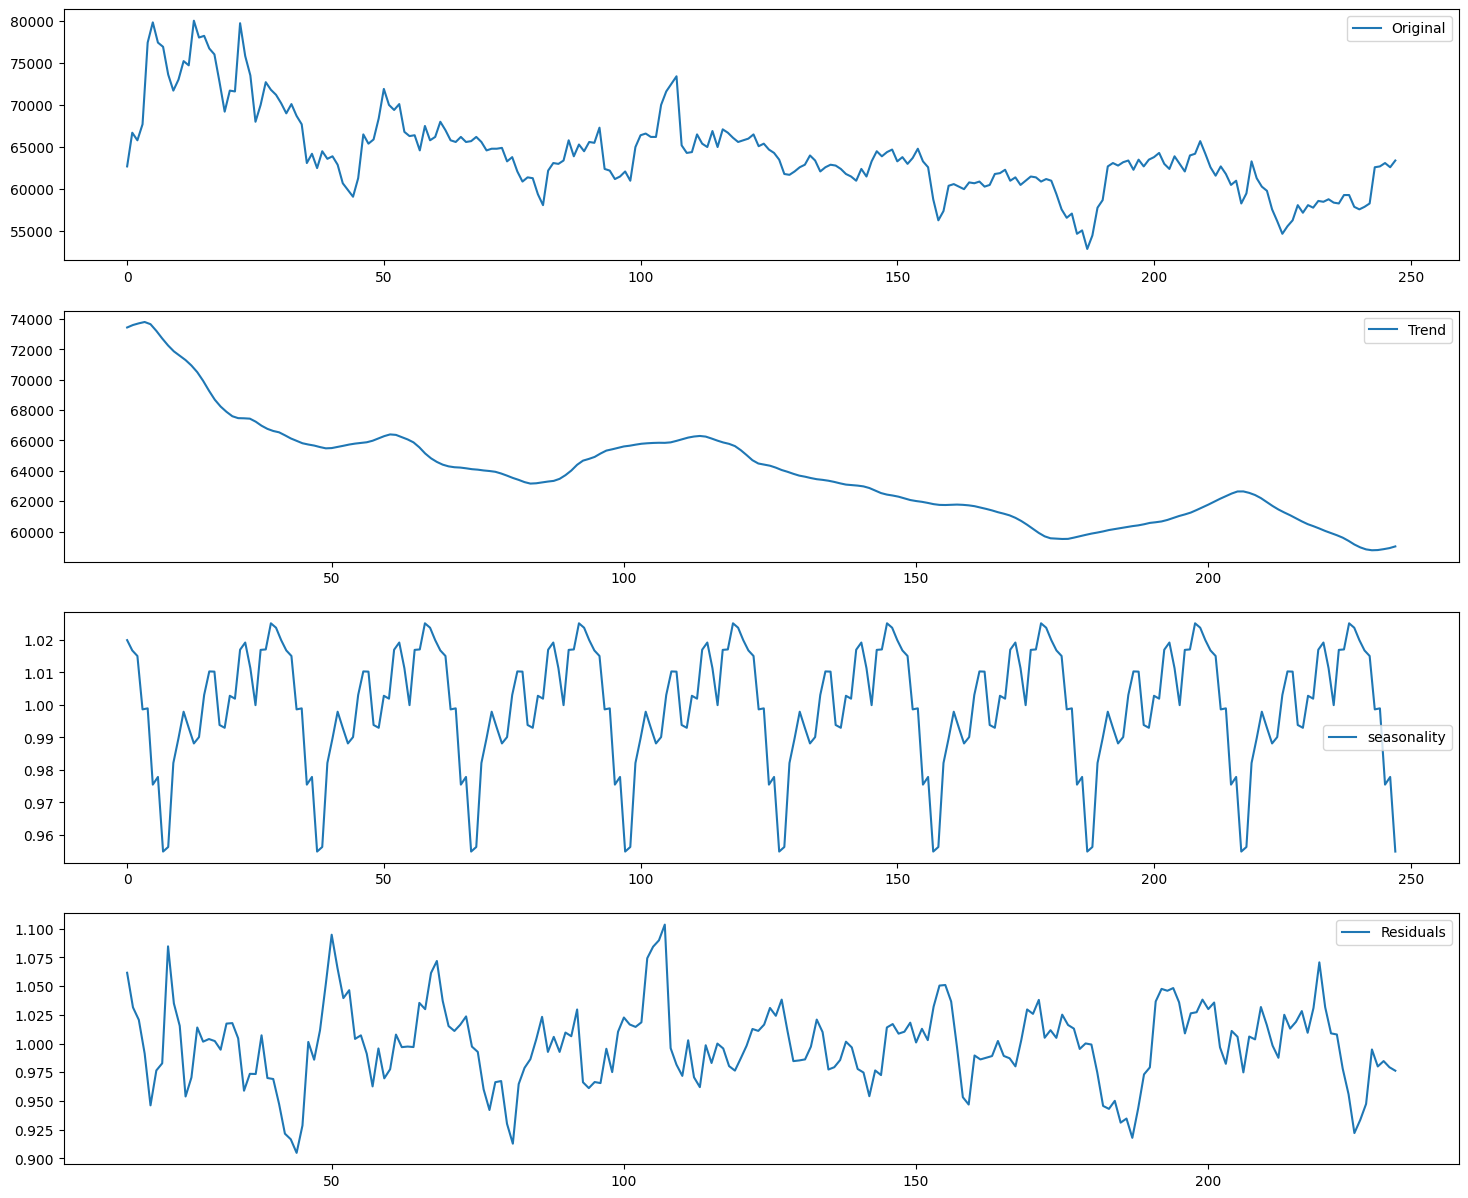

In [50]:
decomposition = seasonal_decompose(mando_ts, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams['figure.figsize'] = (18, 15)
plt.subplot(411)
plt.plot(mando_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

- 계절성을 띄는것을 확인할 수 있습니다.

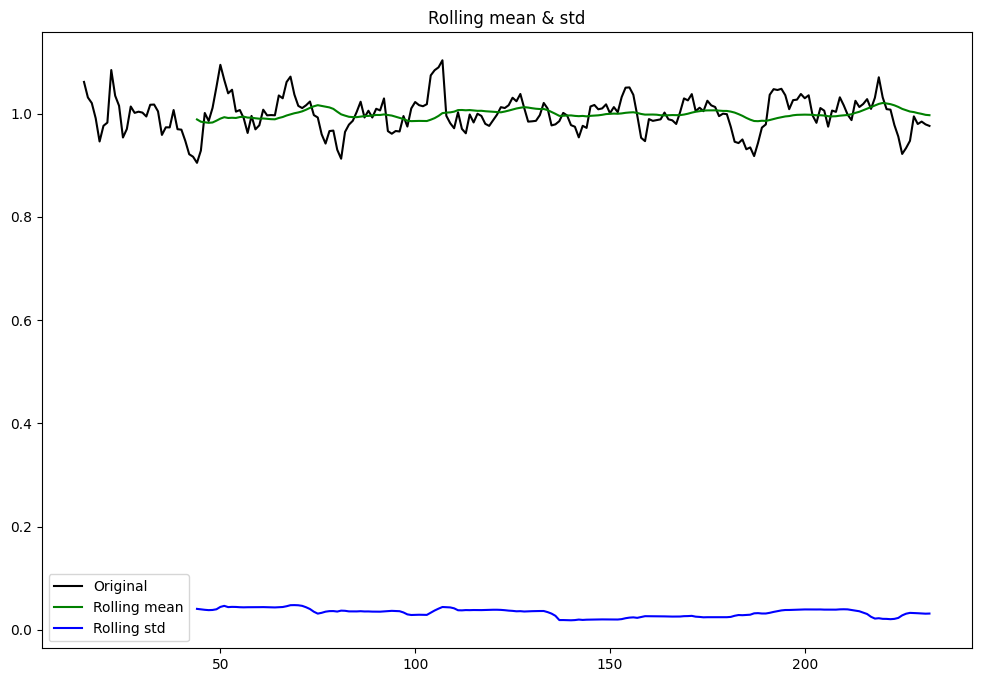

In [51]:
plt.rcParams["figure.figsize"] = (18,12)
plot_rolling_statistics(residual)

In [52]:
residual.isna().sum()

30

In [53]:
len(residual)

248

In [54]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of ADF test
Test Statistic                -6.286836e+00
p-value                        3.680421e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


- residual이 안정적으로 보이는군요. 진행해도 좋을듯 합니다.

## STEP 4 : 학습, 테스트 데이터셋 생성

In [55]:
m_train_data, m_test_data = mando_log[:int(len(mando_log)*0.9)], mando_log[int(len(mando_log)*0.9):]

- 똑같이 90%, 10%의 비율로 train,test 데이터를 분리하였습니다.

(223,)
(25,)


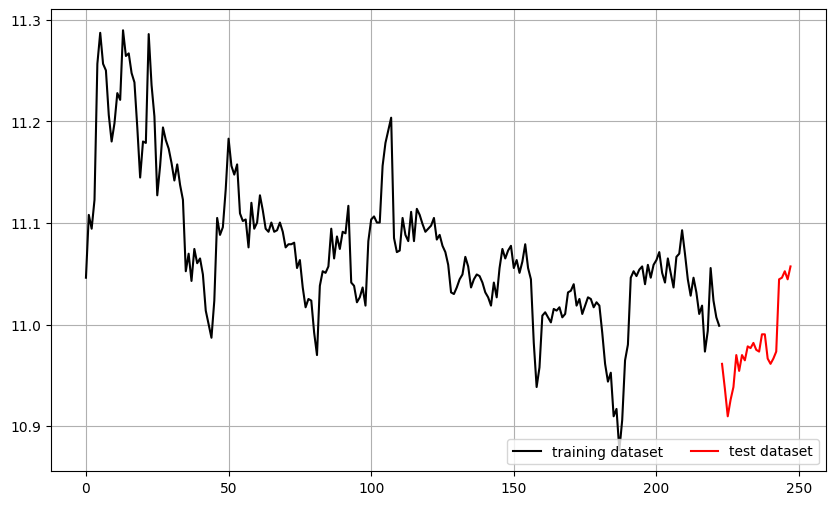

In [56]:
print(m_train_data.shape)
print(m_test_data.shape)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(m_train_data, color='black', label='training dataset')
plt.plot(m_test_data, color='red', label='test dataset')
plt.legend(ncol=2, loc='lower right')
plt.show()

## STEP 5 : 적정 ARIMA 모수 찾기

In [57]:
augmented_dickey_fuller_test(mando_log)

Results of ADF test
Test Statistic                  -2.987266
p-value                          0.036101
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


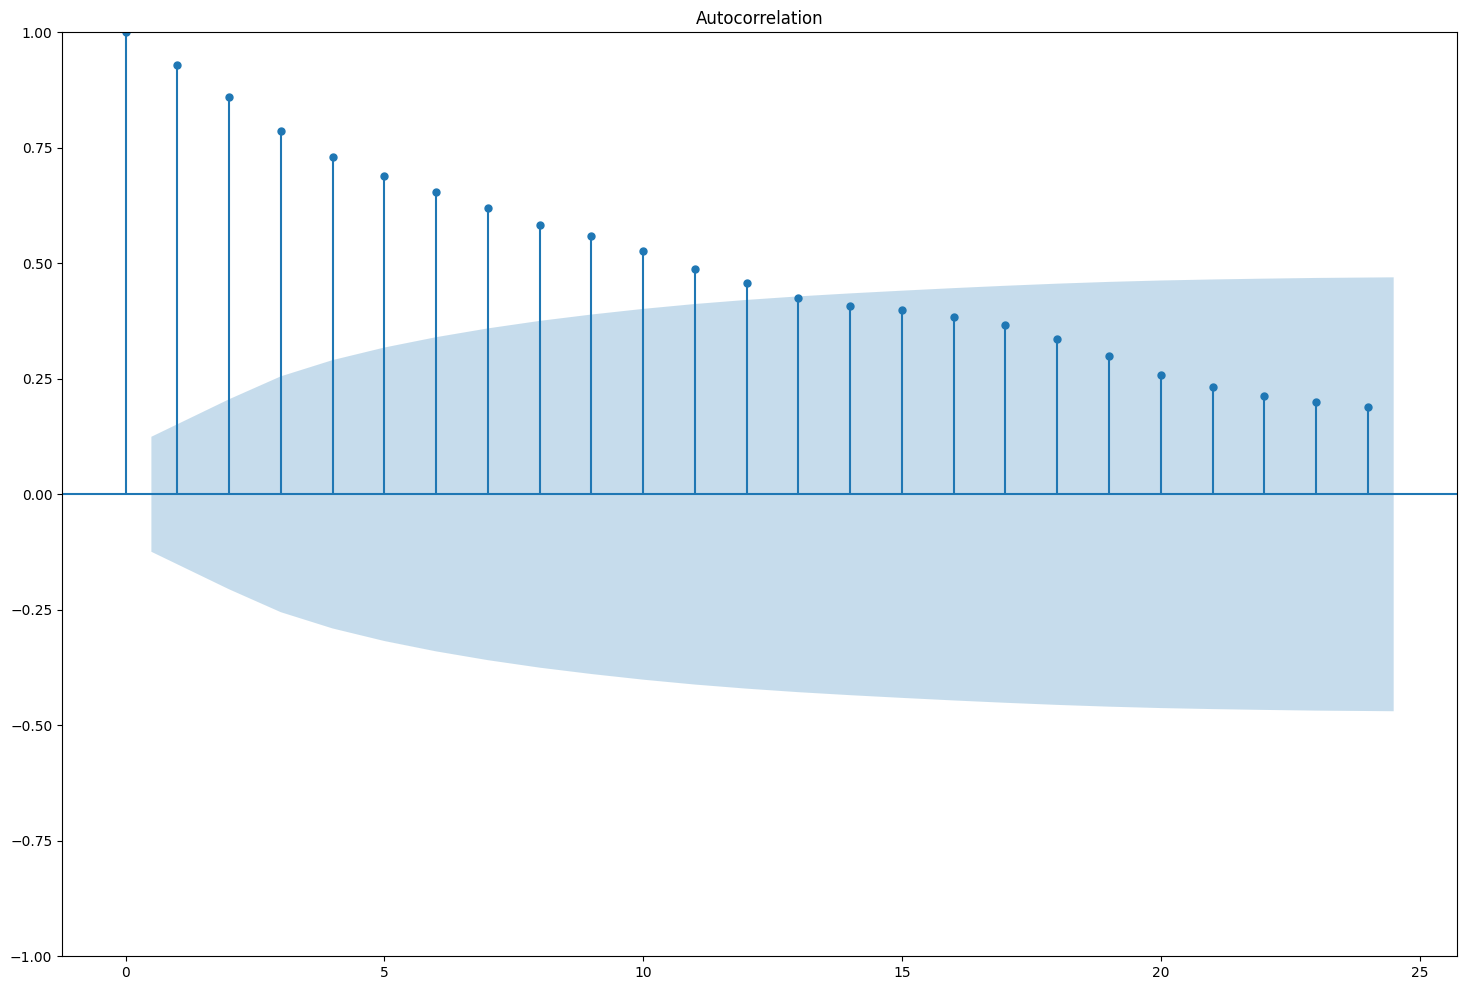

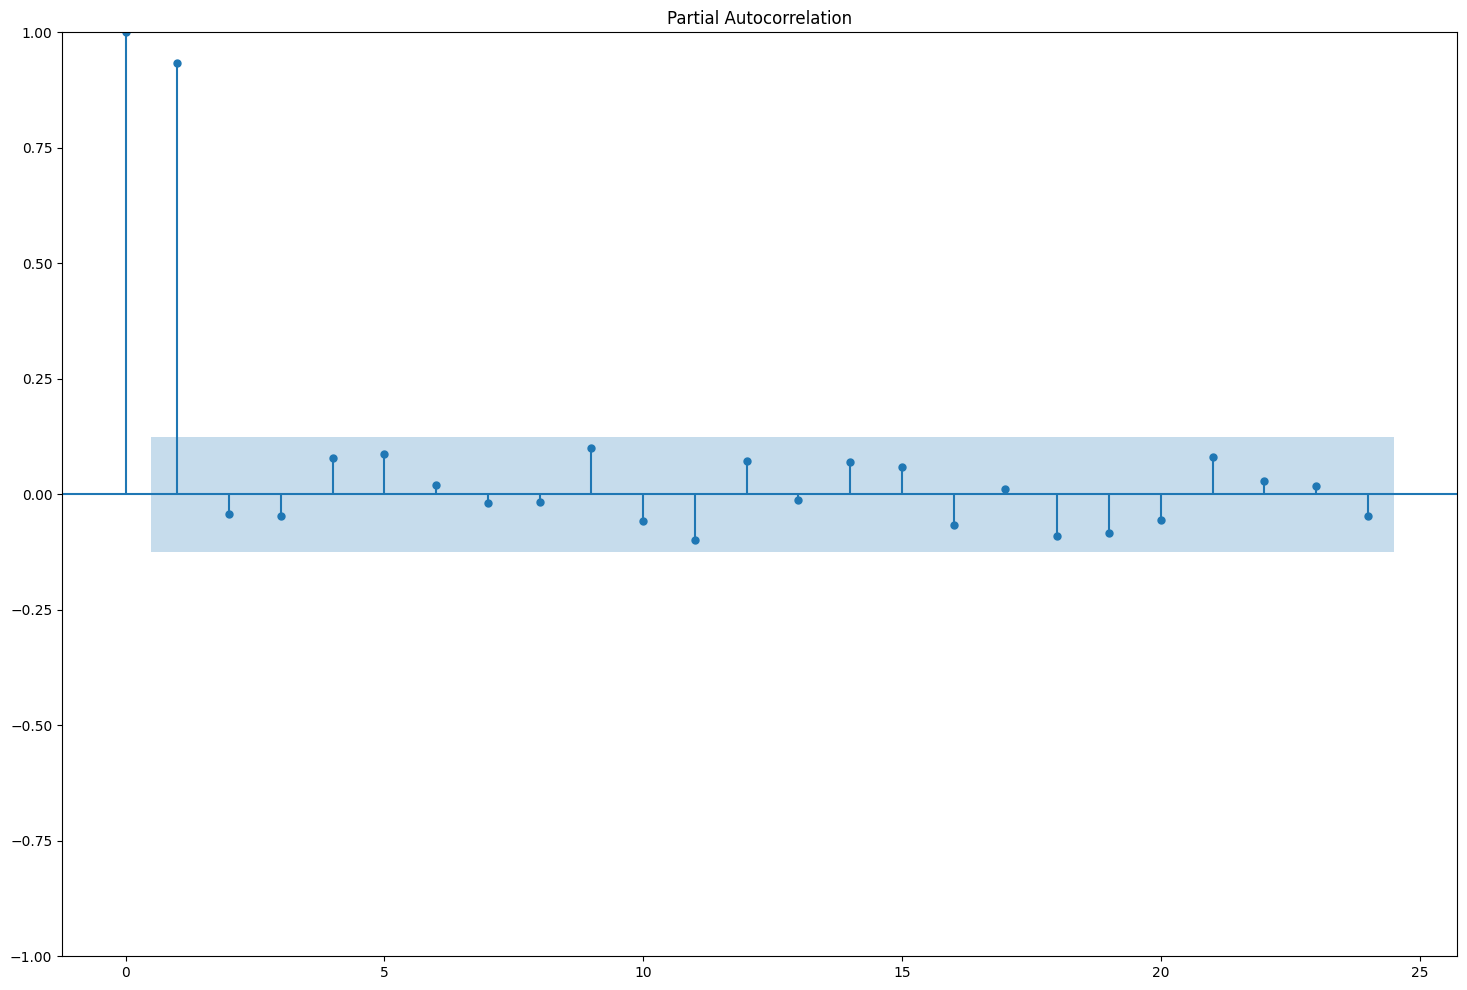

In [58]:
plot_acf(mando_log, alpha = 0.05)
plot_pacf(mando_log, alpha = 0.05)
plt.show()

- 여기서도 MR(12)모형, AR(1) 모형을 보이는군요. 따라서 p = 1, q = 12가 좋아보입니다.

Results of ADF test
Test Statistic                -9.979338e+00
p-value                        2.135298e-17
#Lags Used                     2.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


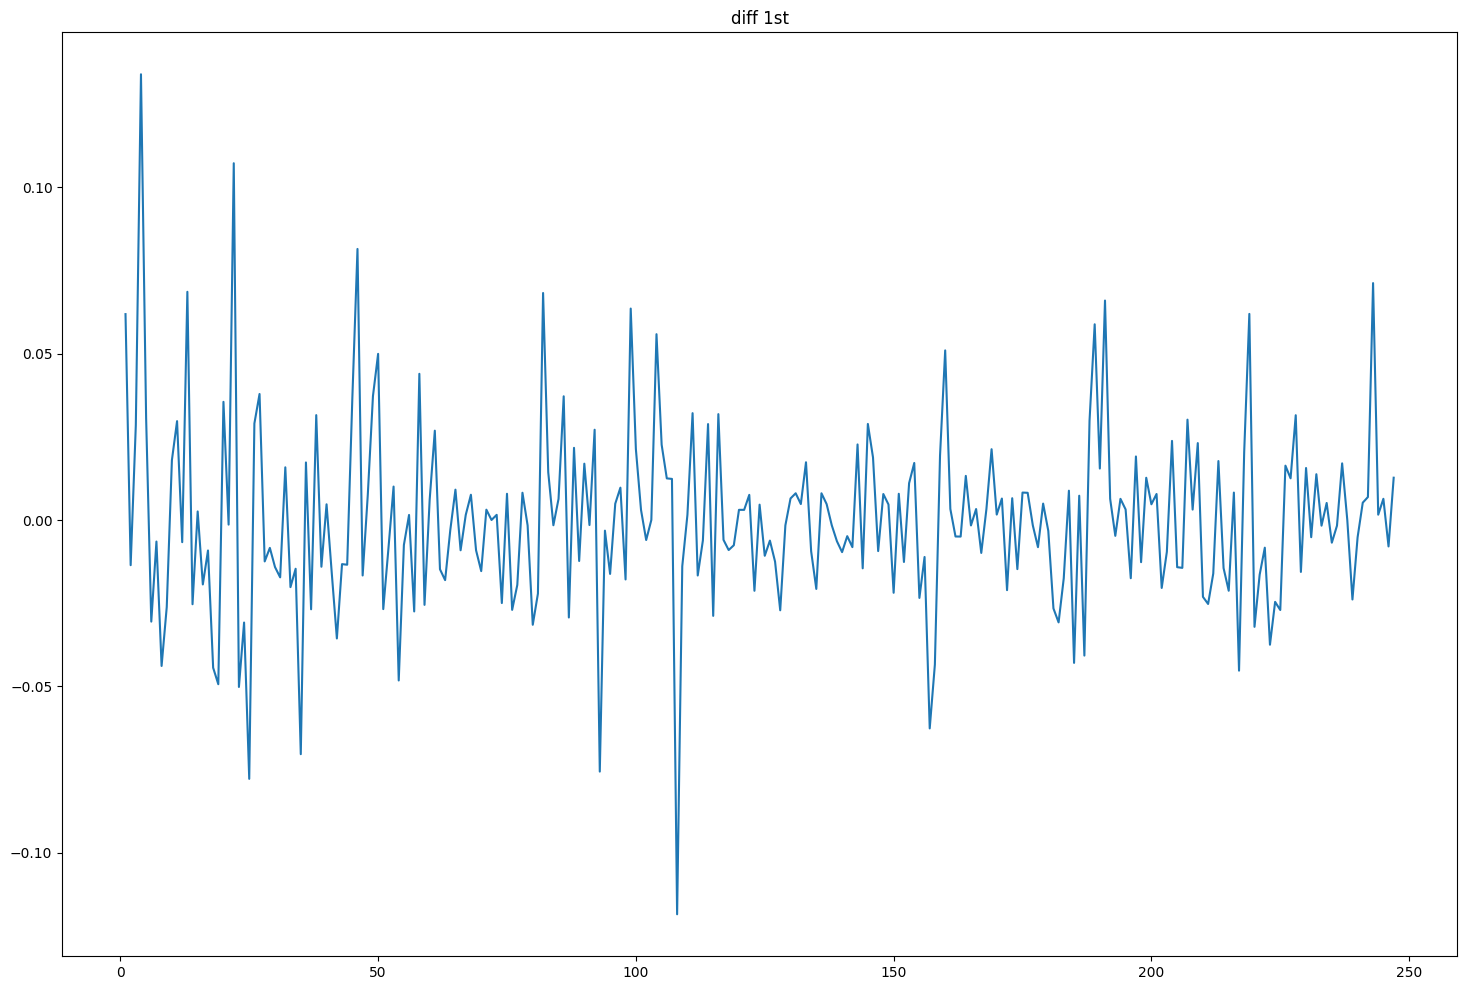

In [59]:
m_diff_1 = mando_log.diff(periods=1).iloc[1:]
m_diff_1.plot(title='diff 1st')

augmented_dickey_fuller_test(m_diff_1)

- 1차 차분을 하였더니 안정성을 띄는 모습을 확인할 수 있습니다.

## STEP 6 : ARIMA 모델 훈련과 테스트

In [60]:
model = ARIMA(m_train_data, order = (0,1,3))

fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(0, 1, 3)   Log Likelihood                 472.727
Date:                Fri, 30 Sep 2022   AIC                           -937.454
Time:                        16:26:03   BIC                           -923.844
Sample:                             0   HQIC                          -931.959
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0250      0.067     -0.375      0.708      -0.156       0.106
ma.L2         -0.0280      0.071     -0.397      0.692      -0.167       0.111
ma.L3         -0.1181      0.057     -2.063      0.0

- 여기서도 q값은 그래프에서 12가 좋아보였지만 P>|z| 값이 유의미하지않아 가장 유의미한 값을 띄는 q = 3을 채택하였습니다.
- p값 또한 그래프상 1이 좋아보였지만 유의미하지 않아 p = 0을 채택하였습니다.

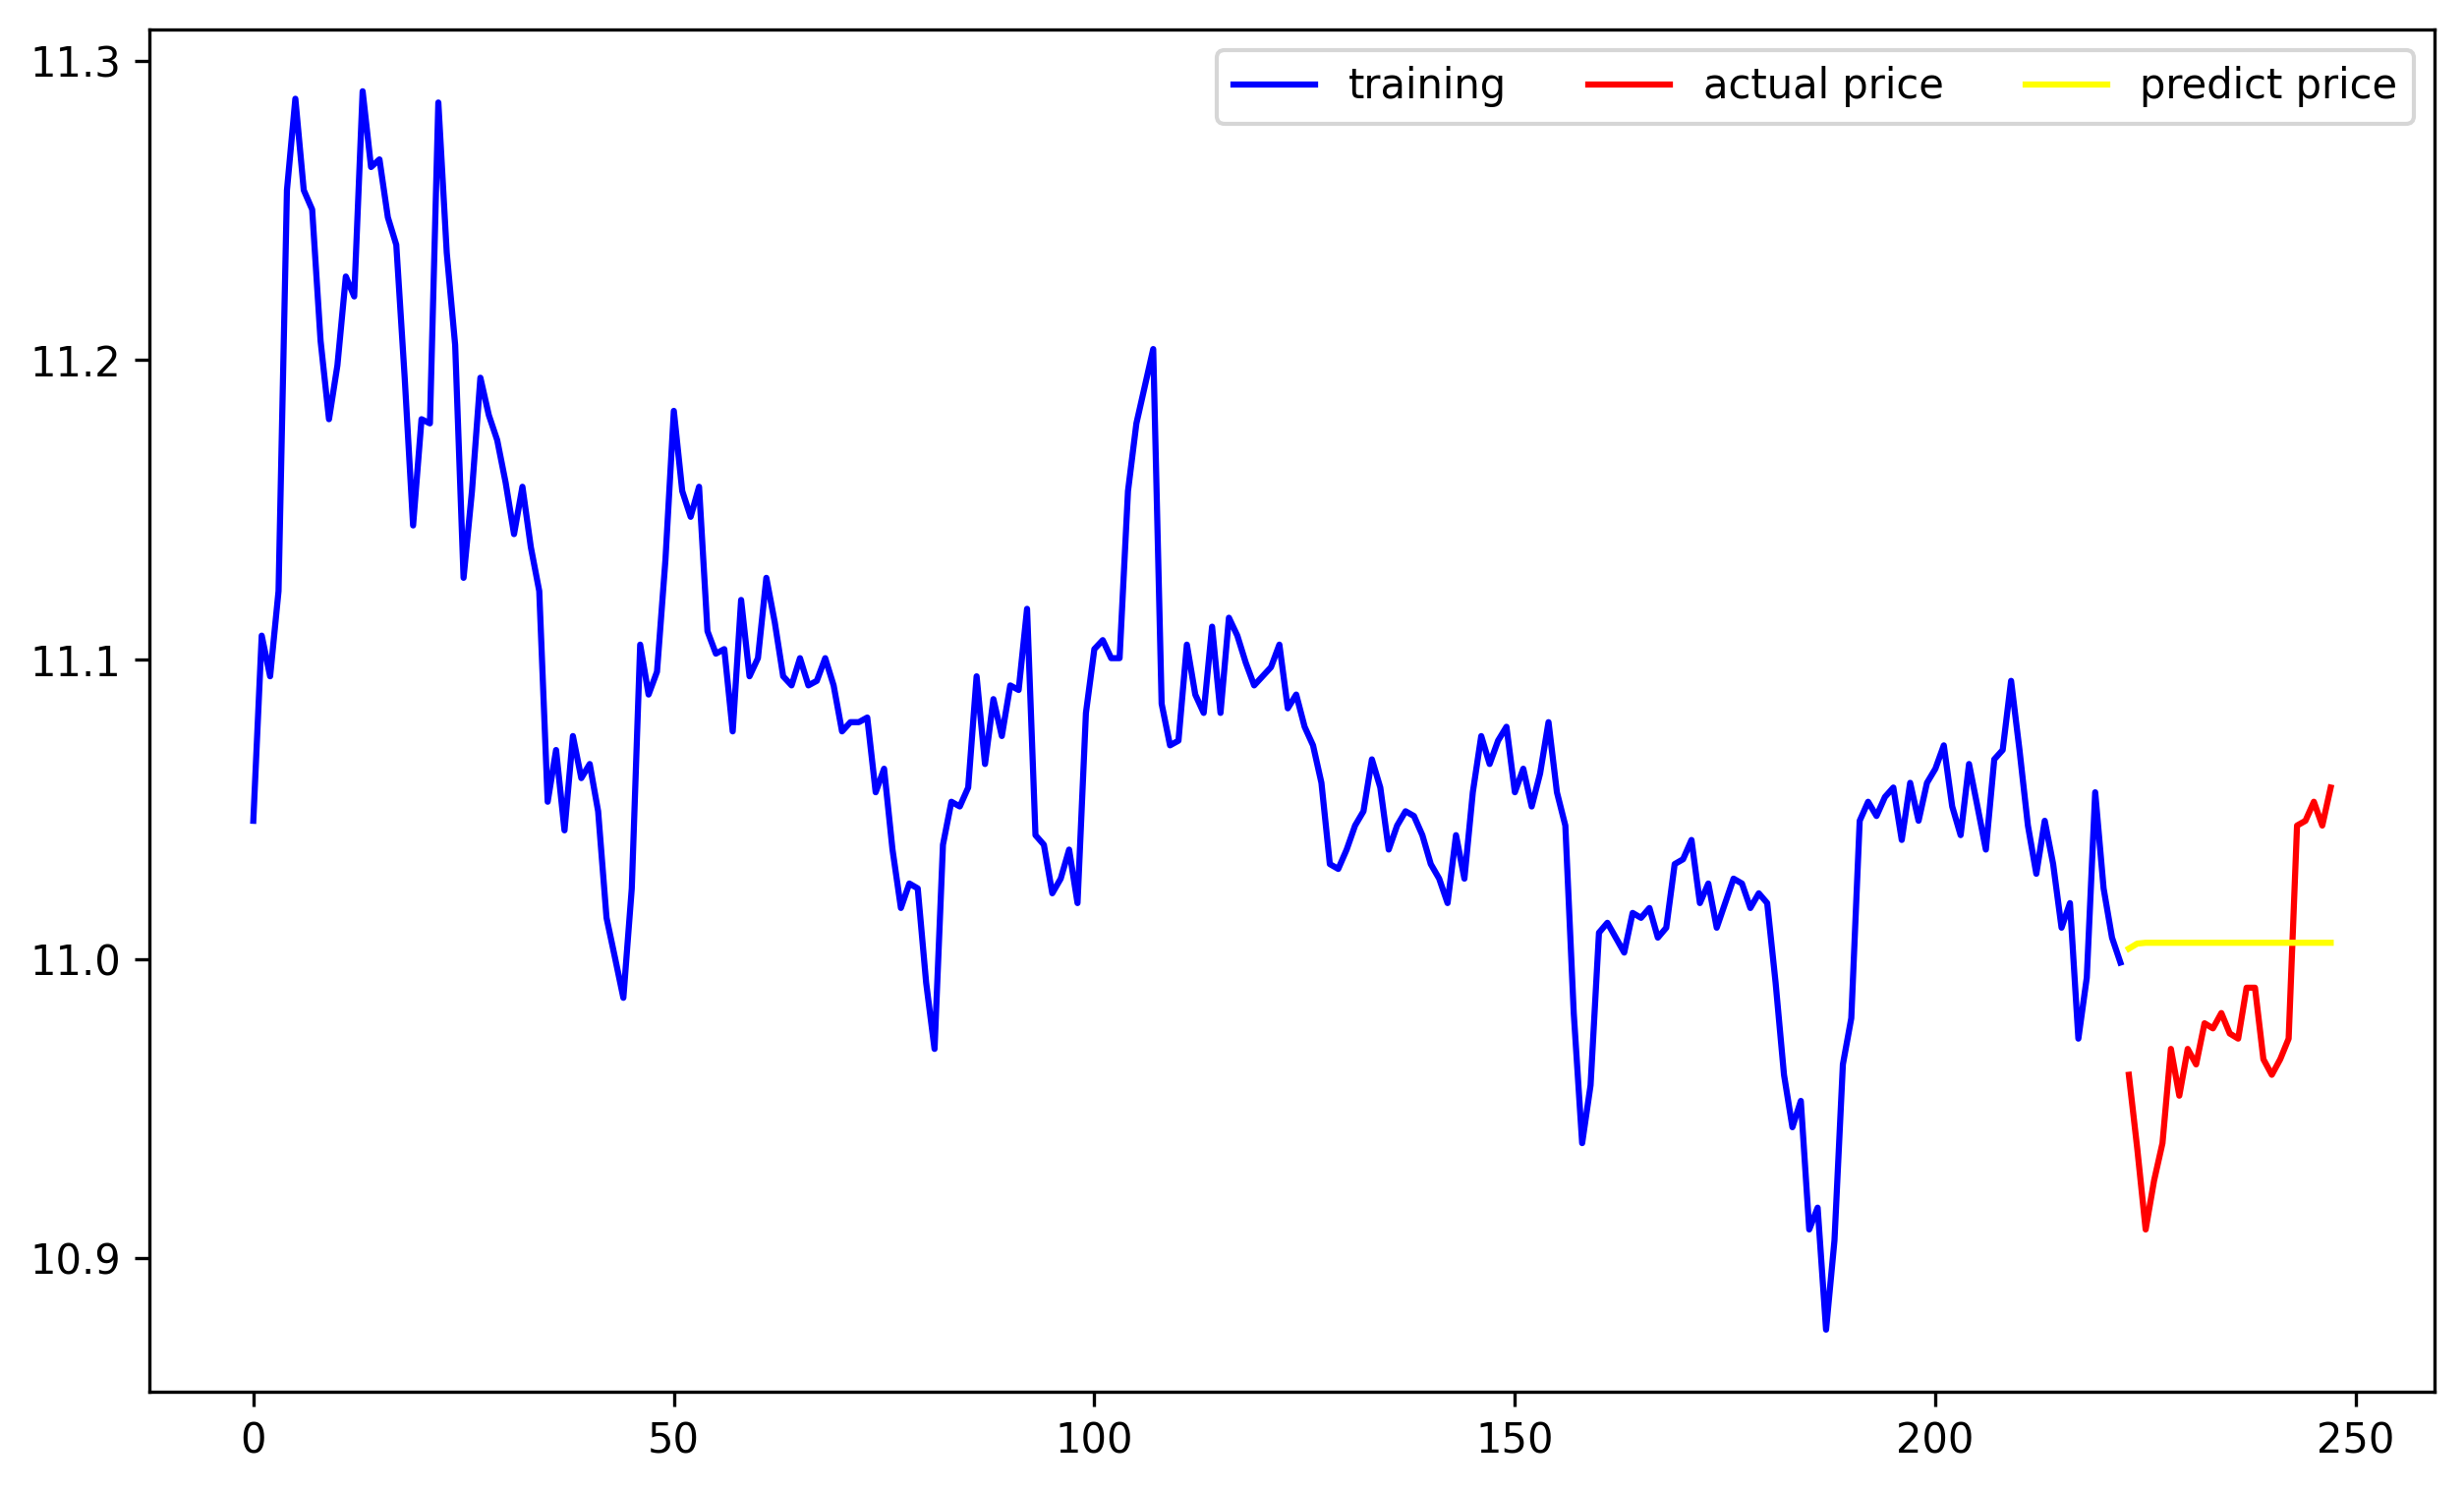

In [61]:
fc = fitted_m.forecast(len(m_test_data), alpha=0.05)

fc_series = pd.Series(fc, index=m_test_data.index)

plt.figure(figsize=(10,6), dpi= 300)
plt.plot(m_train_data, color='blue', label = 'training')
plt.plot(m_test_data, color='red', label = 'actual price')
plt.plot(fc_series, color='yellow', label = 'predict price')
plt.legend(ncol=3, loc='best')
plt.show()

- 그래프가 살짝 어긋났군요. 끝을 잘 예상하지 못한 모습을 볼 수 있습니다.

In [62]:
mse = mean_squared_error(np.exp(m_test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(m_test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(m_test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(m_test_data))/np.abs(np.exp(m_test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7409462.108858859
MAE:  2508.601997894957
RMSE:  2722.0327163461607
MAPE: 4.30%


- 그래프에도 불구하고 MAPE 4.3% 라는 좋은 점수를 보이고 있습니다.
- 이 값 또한 의미가 있어보입니다.

# (2) 회고

>- 이번 프로젝트를 진행하면서 어려웠던 점은 모르는 모듈, 라이브러리 들이 많았습니다. 공부를 하였지만 아직 정확한 의미를 알기는 힘들고 함수 자체만을 사용했기에 이 점이 가장 어려웠습니다.
>  
>  
>  
>- 학습한 내용으로는 잘 몰랐던 모듈들, 혹은 시각화 방법, 통계 등 꽤 색다른것들을 알게 되었습니다.
>- 특히 AR, MR 모형에 대해 잘 이해가 안되었는데 그 부분에 대해서 특히나 많이 공부하였습니다.
>- 또한 도움되었던 내용들은 Reference에 기재해두었습니다.
>  
>  
>- 이번 프로젝트를 통해 알아낸 점은 주식과 같은 시계열 데이터들의 특징들이 매우 흥미로웠습니다. 계절성, 추세, 이동평균선, 이동표준편차 등등 많이 들어봤던 것들도 있었지만 몰랐던 것들을 많이 알게되어 좋았습니다. 특히나 주식에 대해 관심이 크다보니 더욱 흥미로웠던듯 합니다.
>  
>  
>- 루브릭 평가지표를 맞추기 위해 ADF test, ACF plot, PACF plot 들에 대해 깊이 알아보았으며 특히 ACF, PACF plot 들을 집중적으로 알아보았습니다. ADF test 에 대한 설명들이 모호하여 아직 깊게 알지는 못하였으나 여러가지 반복을 통하여 어떠한 것인지, 어떻게 활용해야 하는지에 대해 알게 되었습니다.

# (3) Reference

> - https://kongdols-room.tistory.com/98 matplotlib 참고블로그
> - https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80 시계열 관련 블로그 참고
> - https://blog.naver.com/1515jjj/222886872827 시계열 관련 블로그 참고
> - https://www.statsmodels.org/stable/index.html statsmodels 공식문서 참고

# (4) 자기다짐

> - 이번 프로젝트는 그래도 다른 프로젝트들에 비해 훨씬 수월했습니다. 아마 관심을 갖고있던 분야이기 때문이지 않을까 생각해봤습니다. 이처럼 흥미롭고 재밌게 프로젝트들을 수행할 수 있도록 앞으로 더욱 많은 분야에 흥미와 재미를 느껴보도록 노력해야겠다고 생각하게 되었습니다.
>  
>  
> - 프로젝트를 할때마다 하면 할 수록 더 열심히 공부해야겠다는 생각이 들었지만 이번 프로젝트는 공부하고싶다는 생각도 함께 들게해주었습니다. 앞으로 더욱 노력해야겠다는 생각이 많이 듭니다.